# UdaciSense: Optimized Object Recognition
## Notebook 2: Compression Techniques

 
In this notebook, you'll explore different model compression techniques to meet the requirements:
- The optimized model should be **30% smaller** than the baseline
- The optimized model should **reduce inference time by 40%**
- The optimized model should **maintain accuracy within 5%** of the baseline

You can experiment with different methods:
1. **Post-training**: Quantization, pruning, graph optimizations.
2. **In-training**: Quantization, pruning, distillation.
Optionally, you can choose to implement other techniques too.

Make sure to experiment with at least two different techniques. 
You will need to combine the selected techniques into a multi-step compression pipeline next, so make sure to select techniques that seem  promising individually but also combined.

### Step 1: Set up the environment

In [1]:
# Setup Python path to import utils from parent directory
import sys
import os

# Add parent directory to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"✅ Added {parent_dir} to Python path")
else:
    print(f"✅ Parent directory already in path")

# Make sure that libraries are dynamically re-loaded if changed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')



✅ Added /home/lence/msai/UdaciSense to Python path


In [2]:
# Import necessary libraries
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from compression.post_training.pruning import prune_model
from compression.post_training.quantization import quantize_model
from compression.post_training.graph_optimization import optimize_model, verify_model_equivalence
from compression.in_training.distillation import train_with_distillation, MobileNetV3_Household_Small
from compression.in_training.pruning import train_with_pruning
from compression.in_training.quantization import train_model_qat, QuantizableMobileNetV3_Household

from utils import MAX_ALLOWED_ACCURACY_DROP, TARGET_INFERENCE_SPEEDUP,TARGET_MODEL_COMPRESSION 
from utils.data_loader import get_household_loaders, get_input_size, print_dataloader_stats, visualize_batch
from utils.model import MobileNetV3_Household, load_model, save_model, print_model_summary
from utils.visualization import plot_multiple_models_comparison
from utils.compression import (
    compare_experiments, compare_optimized_model_to_baseline, evaluate_optimized_model, list_experiments,  # For experimentation
    is_quantized  # For quantization
)

In [3]:
# Ignore PyTorch deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # Optional: Ignore all user warnings

In [4]:
# Check if CUDA is available
devices = ["cpu"]
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    devices.extend([f"cuda:{i} ({torch.cuda.get_device_name(i)})" for i in range(num_devices)])
print(f"Devices available: {devices}")

Devices available: ['cpu', 'cuda:0 (NVIDIA GeForce RTX 3080 Ti)']


In [5]:
# Create directories for each technique
compression_types = [
    "post_training/pruning",
    "post_training/quantization",
    "post_training/graph_optimization",
    "in_training/distillation", 
    "in_training/quantization",
    "in_training/pruning",
]
for comp_type in compression_types:
    models_dir = f"../models/{comp_type}"
    models_ckp_dir = f"{models_dir}/checkpoints"
    results_dir = f"../results/{comp_type}"
    
    os.makedirs(models_ckp_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

In [6]:
# Set random seed for reproducibility
def set_deterministic_mode(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    return seed_worker

set_deterministic_mode(42)
g = torch.Generator()
g.manual_seed(42)

### Step 2: Load the dataset

Extracting household classes from CIFAR100 for train set...
Extracting household classes from CIFAR100 for test set...
Input has size: (1, 3, 32, 32)
Datasets have these classes: 
  0: clock
  1: keyboard
  2: lamp
  3: telephone
  4: television
  5: bed
  6: chair
  7: couch
  8: table
  9: wardrobe

Information on train set
Statistics for train
 Size: 5000
 Samples per class:
  clock: 500
  keyboard: 500
  lamp: 500
  telephone: 500
  television: 500
  bed: 500
  chair: 500
  couch: 500
  table: 500
  wardrobe: 500
Examples of images from the train set


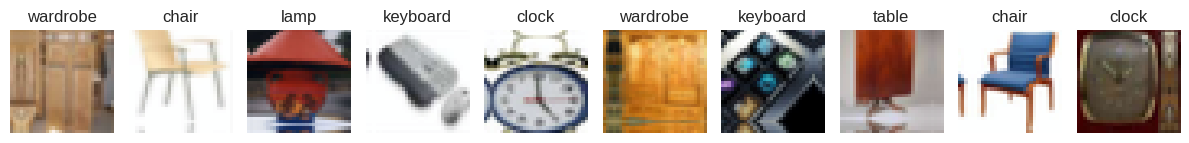


Information on test set
Statistics for test
 Size: 1000
 Samples per class:
  clock: 100
  keyboard: 100
  lamp: 100
  telephone: 100
  television: 100
  bed: 100
  chair: 100
  couch: 100
  table: 100
  wardrobe: 100
Examples of images from the test set


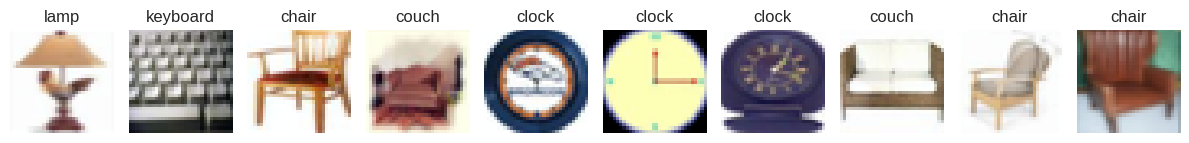

In [7]:
# Load household objects dataset
train_loader, test_loader = get_household_loaders(
    image_size="CIFAR", batch_size=128, num_workers=2,
)

# Get input_size
input_size = get_input_size("CIFAR")
print(f"Input has size: {input_size}")

# Get class names
class_names = train_loader.dataset.classes
print(f"Datasets have these classes: ")
for i in range(len(class_names)):
    print(f"  {i}: {class_names[i]}")

# Visualize some examples
for dataset_type, data_loader in [('train', train_loader), ('test', test_loader)]:
    print(f"\nInformation on {dataset_type} set")
    print_dataloader_stats(data_loader, dataset_type)
    print(f"Examples of images from the {dataset_type} set")
    visualize_batch(data_loader, num_images=10)

### Step 3: Load the baseline model and metrics

In [8]:
# Load the baseline model
baseline_model = MobileNetV3_Household()
baseline_model_name = "baseline_mobilenet"
baseline_model.load_state_dict(torch.load(f"../models/{baseline_model_name}/checkpoints/model.pth"))
print_model_summary(baseline_model)

# Load baseline metrics
with open(f"../results/{baseline_model_name}/metrics.json", "r") as f:
    baseline_metrics = json.load(f)

print("\nBaseline Model Metrics:")
pprint.pp(baseline_metrics)

# Calculate target metrics based on CTO requirements
target_model_size = baseline_metrics['size']['model_size_mb'] * (1 - TARGET_MODEL_COMPRESSION)
target_inference_time_cpu = baseline_metrics['timing']['cpu']['avg_time_ms'] * (1 - TARGET_INFERENCE_SPEEDUP)
if torch.cuda.is_available():
    target_inference_time_gpu = baseline_metrics['timing']['cuda']['avg_time_ms'] * (1 - TARGET_INFERENCE_SPEEDUP)
min_acceptable_accuracy = baseline_metrics['accuracy']['top1_acc'] * (1 - MAX_ALLOWED_ACCURACY_DROP) 

print("Optimization Targets:")
print(f"Target Model Size: {baseline_metrics['size']['model_size_mb']:.2f} --> {target_model_size:.2f} MB ({TARGET_MODEL_COMPRESSION*100}% reduction)")
print(f"Target Inference Time (CPU): {baseline_metrics['timing']['cpu']['avg_time_ms']:.2f} --> {target_inference_time_cpu:.2f} ms ({TARGET_INFERENCE_SPEEDUP*100}% reduction)")
if torch.cuda.is_available():
    print(f"Target Inference Time (GPU): {baseline_metrics['timing']['cuda']['avg_time_ms']:.2f} --> {target_inference_time_gpu:.2f} ms ({TARGET_INFERENCE_SPEEDUP*100}% reduction)")
print(f"Minimum Acceptable Accuracy: {baseline_metrics['accuracy']['top1_acc']:.2f} --> {min_acceptable_accuracy:.2f} (within {MAX_ALLOWED_ACCURACY_DROP*100}% of baseline)")

Model Architecture:
MobileNetV3_Household(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
   

### Step 4: Implement and evaluate compression techniques

Now you'll implement and evaluate different compression techniques. For each technique that you choose, you'll:
1. Implement the technique
2. Evaluate its impact on model size, inference time, and accuracy
3. Analyze the trade-offs

To choose a technique, simply uncomment the apply_{TECHNIQUE_NAME}_technique() function call in the corresponding technique cell block.

#### 4.1 Post-Training - Quantization

Quantization reduces the precision of weights and activations, converting floating-point values to integers.


Applying dynamic quantization with fbgemm backend
Applying dynamic quantization...
Dynamic quantization complete
Model saved to ../models/post_training/quantization/dynamic/model.pth
✅ Model is quantized

Evaluating performance of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


Baseline metrics saved at ../results/post_training/quantization/dynamic/metrics.json.


Calculating confusion matrix: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Confusion matrix saved to ../results/post_training/quantization/dynamic/confusion_matrix.png


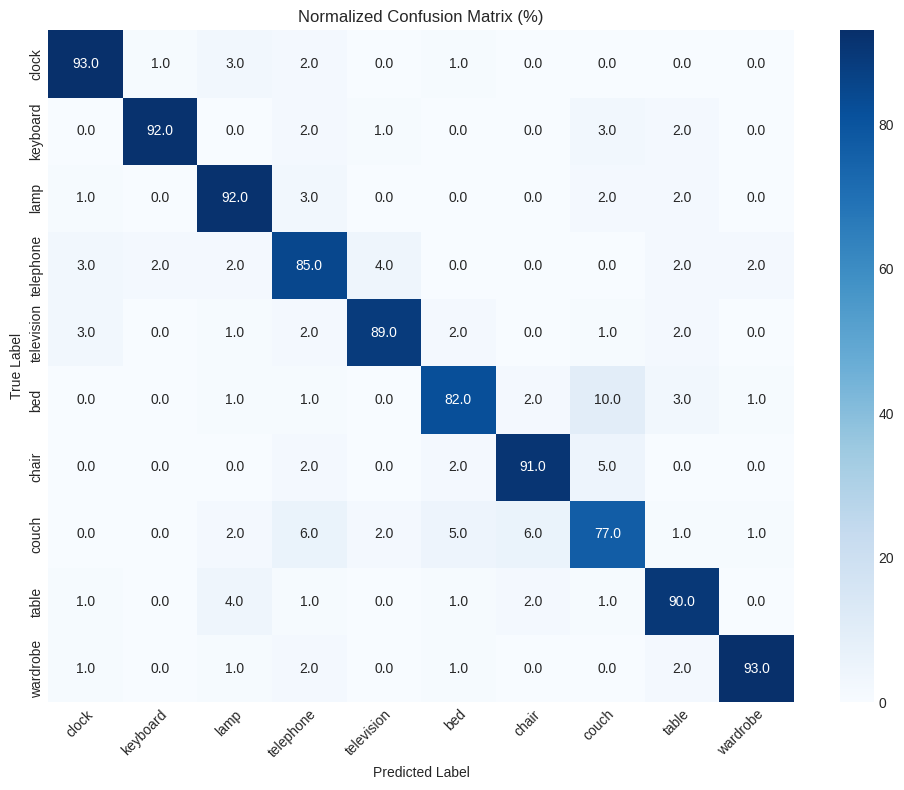


Optimized Model Metrics (post_training/quantization/dynamic):
Accuracy: 88.40%
Model Size: 4.24 MB
CPU Inference Time: 5.26 ms (190.09 FPS)

Comparing performance of optimized model against baseline...
Get metrics of baseline model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


Get metrics of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


Model comparison plot saved to ../results/post_training/quantization/dynamic/comparison.png


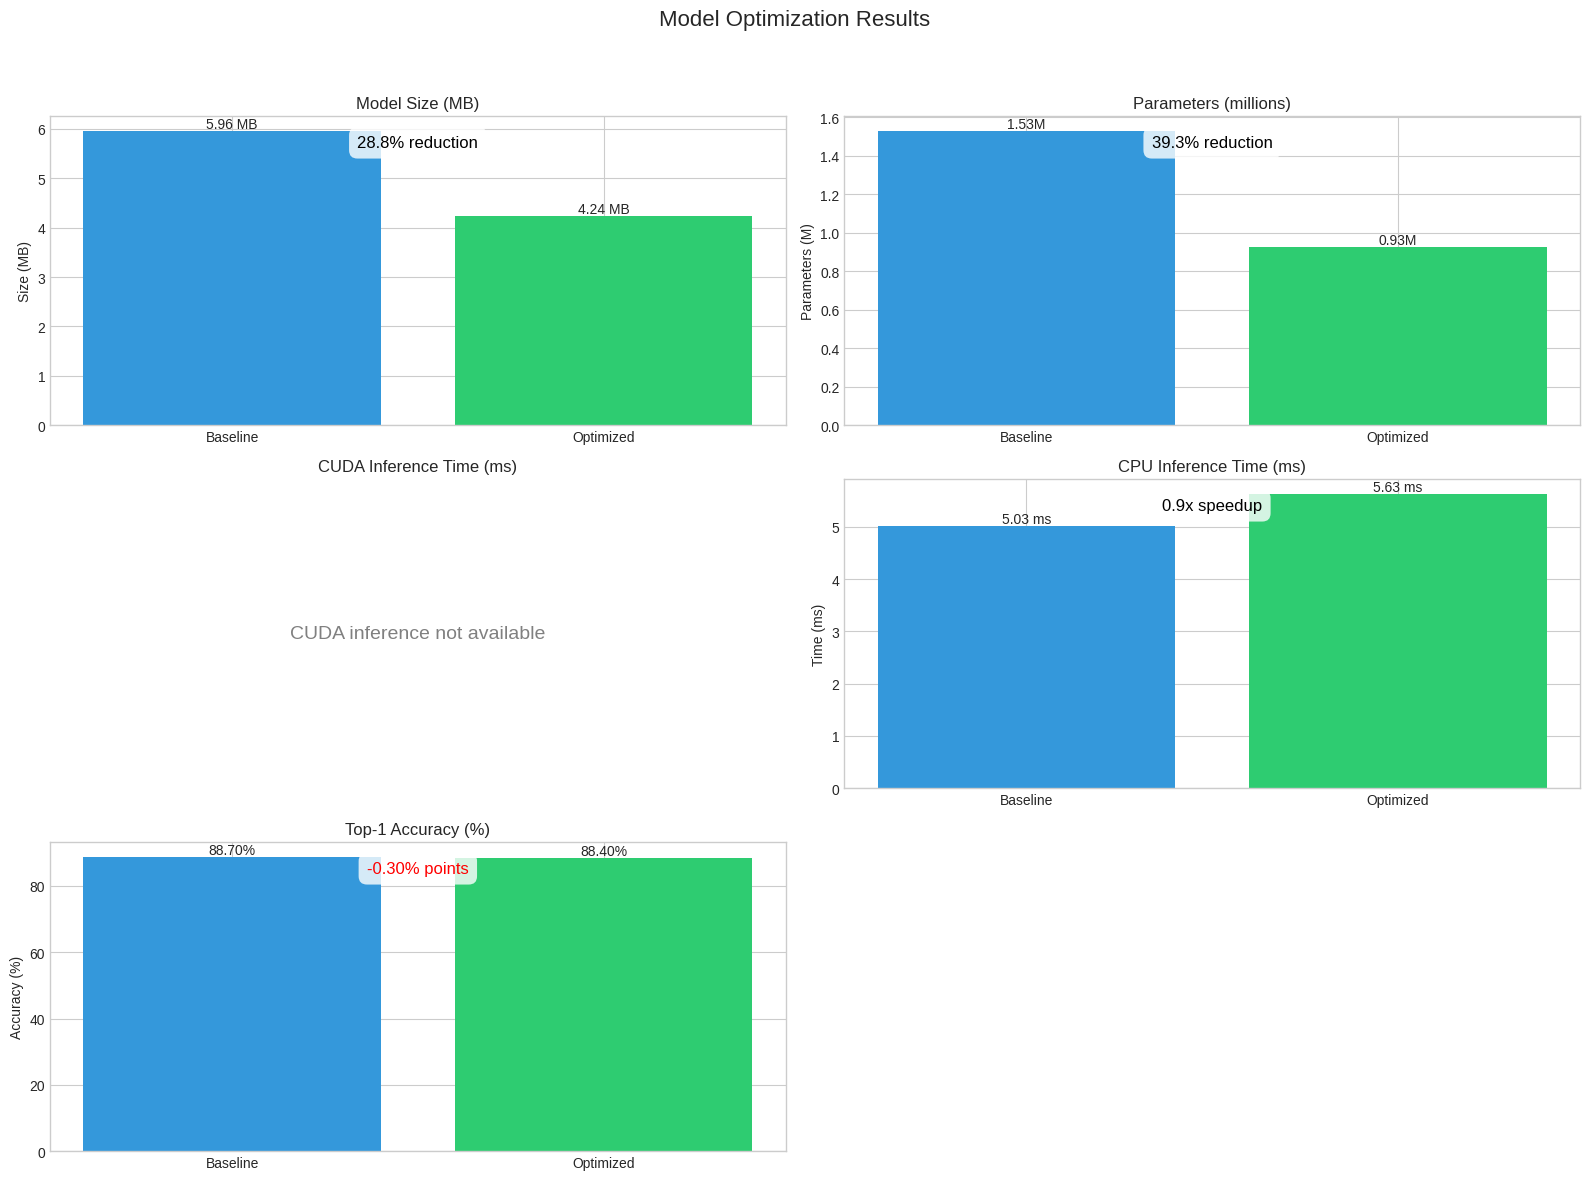


post_training/quantization/dynamic Results:
Model Size: 4.24 MB (28.8% reduction)
Parameters: 927,008 (39.3% reduction)
CPU Inference Time: 5.63 ms (0.9x speedup)
Accuracy: 88.40% (-0.30% change)
Requirements met: False


In [9]:
# Define a function to apply quantization and evaluate results
def apply_post_training_quantization(quantization_type, backend, device):
    """
    Apply quantization to a model with given method and backend.
    
    Args:
        quantization_type: Quantization method ("static" or "dynamic")
        backend: Backend for quantization ("fbgemm" for x86 or "qnnpack" for ARM)
        device: Which device to use for model loading, training, and evaluation
        
    Returns:
        Tuple of (optimized_model, comparison_results, experiment_name)
    """
    # Define unique experiment name given main parameters
    experiment_name = f"post_training/quantization/{quantization_type}"
    
    # Create experiment subdirectories
    os.makedirs(f"../models/{experiment_name}", exist_ok=True)
    os.makedirs(f"../results/{experiment_name}", exist_ok=True)
    
    print(f"Applying {quantization_type} quantization with {backend} backend")
    
    # Make a copy of the baseline model and move to specified device
    orig_model = load_model(f"../models/{baseline_model_name}/checkpoints/model.pth").to(device)
    orig_model.eval()
    
    # Apply post-training quantization
    # TODO: IMPLEMENT THIS FUNCTION IN THE compression/ FOLDER    
    quantized_model = quantize_model(
        orig_model,
        quantization_type=quantization_type,
        calibration_data_loader=train_loader if quantization_type == "static" else None,
        calibration_num_batches=1 if quantization_type == "static" else None,  # Set this to the desired value
        backend=backend,
    )
    
    # Save the quantized model
    save_model(quantized_model, f"../models/{experiment_name}/model.pth")
    
    # Check that model is indeed quantized
    is_quantized(quantized_model)
    
    # Evaluate quantized model
    evaluate_optimized_model(
        quantized_model, test_loader, experiment_name, class_names, input_size, device=torch.device('cpu')
    )
    
    # Compare with baseline model for performance differences
    comparison_results = compare_optimized_model_to_baseline(
        baseline_model,
        quantized_model,
        experiment_name,
        test_loader,
        class_names,
        device=torch.device('cpu'),
    )
    
    return quantized_model, comparison_results, experiment_name

#### Apply post-training quantization
## Find info at https://pytorch.org/docs/stable/quantization.html

## TODO: Experiment with different configurations
## Feel free to add more configuration parameters (and update the script in `compression/` folder accordingly)
quantization_type = "dynamic"  # One of "dynamic" or "static"
backend = "fbgemm"  # One of "fbgemm" (x86/Intel/AMD) or "qnnpack" (ARM)
device = torch.device('cpu')  # Define using torch.device()

# Optimize and evaluate model
quantized_model_static, quantized_comparison_results, experiment_name = apply_post_training_quantization(quantization_type, backend=backend, device=device)

#### 4.2 In-training - Quantization

Quantization-aware training simulates quantization during training, allowing the model to adapt to the reduced precision.

Applying quantization-aware training with QAT starting at epoch 3 / ending at 10
Training with quantization-aware training for 10 epochs
QAT start epoch: 3, Finetune BN stats epochs: 6
QAT will be activated after epoch 3


Epoch 1/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 32.52it/s, loss=7.42, acc=55.5]


Epoch 1/10 - Train Loss: 1.0551, Train Acc: 64.62%, Test Loss: 1.8557, Test Acc: 55.50%, LR: 0.001000, Time: 2.45s


Epoch 2/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 34.52it/s, loss=2.68, acc=71]  


Epoch 2/10 - Train Loss: 0.5092, Train Acc: 82.52%, Test Loss: 1.0059, Test Acc: 71.00%, LR: 0.001000, Time: 1.95s


Epoch 3/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s, loss=2.75, acc=73]  


Epoch 3/10 - Train Loss: 0.3783, Train Acc: 87.34%, Test Loss: 1.0323, Test Acc: 73.00%, LR: 0.001000, Time: 1.94s

Starting QAT at epoch 4

Preparing model for QAT with backend: fbgemm
Fusing model layers...
Model prepared for QAT


Epoch 4/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 21.35it/s, loss=4.33, acc=11.8]


Epoch 4/10 - Train Loss: 2.1628, Train Acc: 27.00%, Test Loss: 3.2449, Test Acc: 11.80%, LR: 0.001000, Time: 3.53s
New best QAT model! Saving... (11.80%)
Model saved to /home/lence/msai/UdaciSense/notebooks/../models/in_training/quantization/epochs10_start3/checkpoints


Epoch 5/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 21.14it/s, loss=3.02, acc=35]  


Epoch 5/10 - Train Loss: 1.6106, Train Acc: 43.68%, Test Loss: 2.2620, Test Acc: 35.00%, LR: 0.001000, Time: 3.30s
New best QAT model! Saving... (35.00%)
Model saved to /home/lence/msai/UdaciSense/notebooks/../models/in_training/quantization/epochs10_start3/checkpoints


Epoch 6/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 21.32it/s, loss=3, acc=38.7]   


Epoch 6/10 - Train Loss: 1.3593, Train Acc: 53.20%, Test Loss: 2.2503, Test Acc: 38.70%, LR: 0.001000, Time: 3.29s
New best QAT model! Saving... (38.70%)
Model saved to /home/lence/msai/UdaciSense/notebooks/../models/in_training/quantization/epochs10_start3/checkpoints


Epoch 7/10 [Train]: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s, loss=1.69, batch_acc=37.5, running_acc=56.5, lr=0.001]



Freezing batch norm statistics...


Epoch 7/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 21.47it/s, loss=2.44, acc=41.3]


Epoch 7/10 - Train Loss: 1.2657, Train Acc: 56.54%, Test Loss: 1.8283, Test Acc: 41.30%, LR: 0.001000, Time: 3.28s
New best QAT model! Saving... (41.30%)
Model saved to /home/lence/msai/UdaciSense/notebooks/../models/in_training/quantization/epochs10_start3/checkpoints


Epoch 8/10 [Train]: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s, loss=1.27, batch_acc=62.5, running_acc=57.6, lr=0.001]



Disabling observers...

Freezing batch norm statistics...


Epoch 8/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 21.06it/s, loss=2.68, acc=39.3]


Epoch 8/10 - Train Loss: 1.2314, Train Acc: 57.56%, Test Loss: 2.0124, Test Acc: 39.30%, LR: 0.001000, Time: 3.30s


Epoch 9/10 [Train]: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s, loss=1.91, batch_acc=25, running_acc=63.5, lr=0.001]   



Freezing batch norm statistics...


Epoch 9/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 21.25it/s, loss=2.01, acc=53.1]


Epoch 9/10 - Train Loss: 1.0609, Train Acc: 63.46%, Test Loss: 1.5039, Test Acc: 53.10%, LR: 0.001000, Time: 3.28s
New best QAT model! Saving... (53.10%)
Model saved to /home/lence/msai/UdaciSense/notebooks/../models/in_training/quantization/epochs10_start3/checkpoints


Epoch 10/10 [Train]: 100%|██████████| 40/40 [00:02<00:00, 13.71it/s, loss=1.07, batch_acc=50, running_acc=67.7, lr=0.001]   



Freezing batch norm statistics...


Epoch 10/10 [Test]: 100%|██████████| 8/8 [00:00<00:00, 21.61it/s, loss=2.2, acc=51]   


Epoch 10/10 - Train Loss: 0.9562, Train Acc: 67.70%, Test Loss: 1.6487, Test Acc: 51.00%, LR: 0.001000, Time: 3.30s
Training completed. Best accuracy: 73.00%
Best QAT checkpoint saved as '/home/lence/msai/UdaciSense/notebooks/../models/in_training/quantization/epochs10_start3/checkpoints' at epoch 9 (acc=53.10%)
Converting best QAT model to fully quantized model...
Converting QAT model to fully quantized model...
Disabling observers...
Freezing batch norm...
Performing quantization conversion...
Conversion complete
Model saved to ../models/in_training/quantization/epochs10_start3/model.pth
✅ Model is quantized

Evaluating performance of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:01<00:00,  6.53it/s]


Baseline metrics saved at ../results/in_training/quantization/epochs10_start3/metrics.json.


Calculating confusion matrix: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Confusion matrix saved to ../results/in_training/quantization/epochs10_start3/confusion_matrix.png


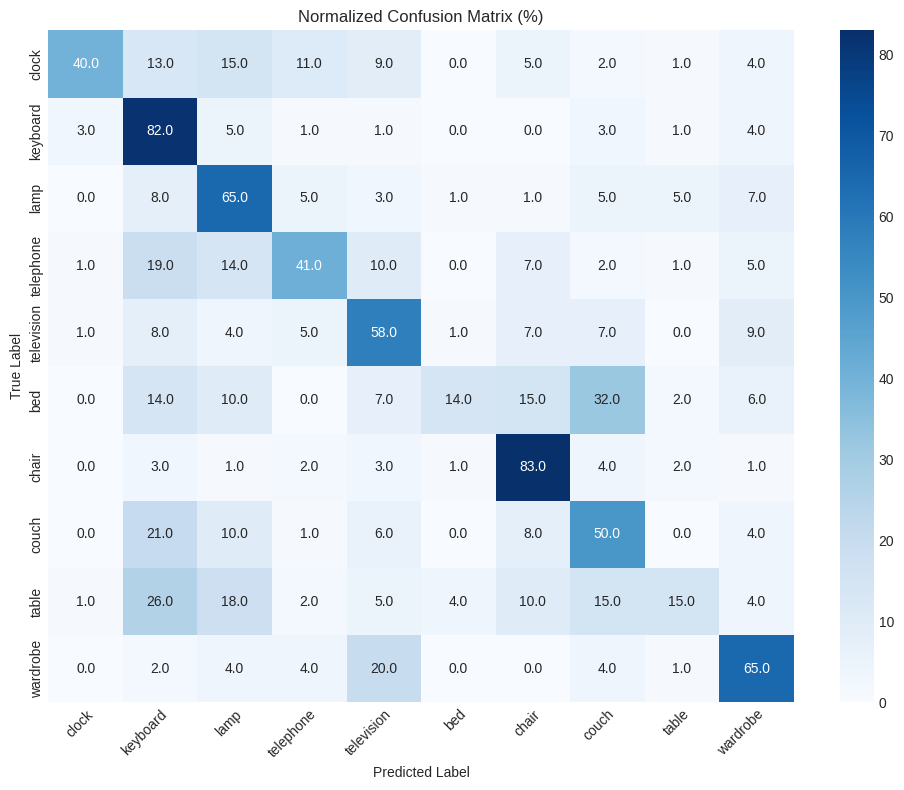

No suitable layers found for weight distribution visualization.
Training history plot saved to ../results/in_training/quantization/epochs10_start3/training_history.png


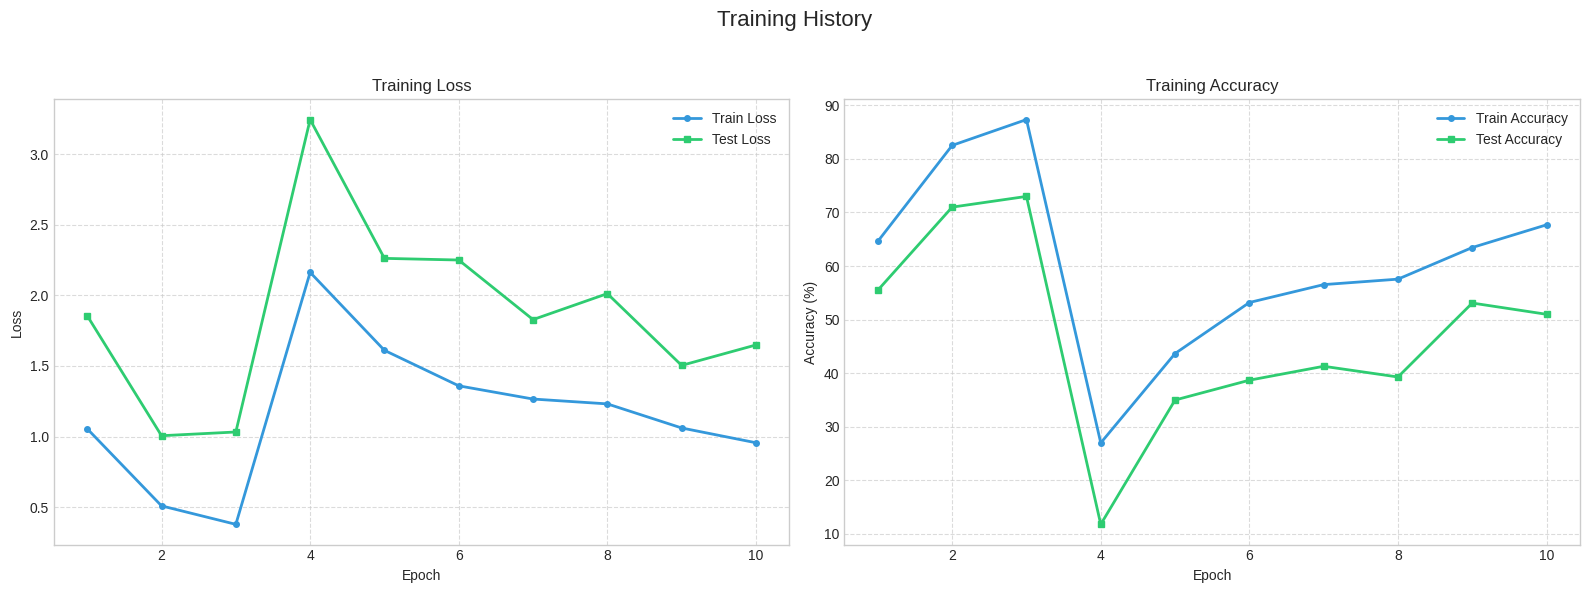


Optimized Model Metrics (in_training/quantization/epochs10_start3):
Accuracy: 50.70%
Model Size: 1.89 MB
CPU Inference Time: 6.02 ms (166.18 FPS)

Comparing performance of optimized model against baseline...
Get metrics of baseline model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Get metrics of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:01<00:00,  6.46it/s]


Model comparison plot saved to ../results/in_training/quantization/epochs10_start3/comparison.png


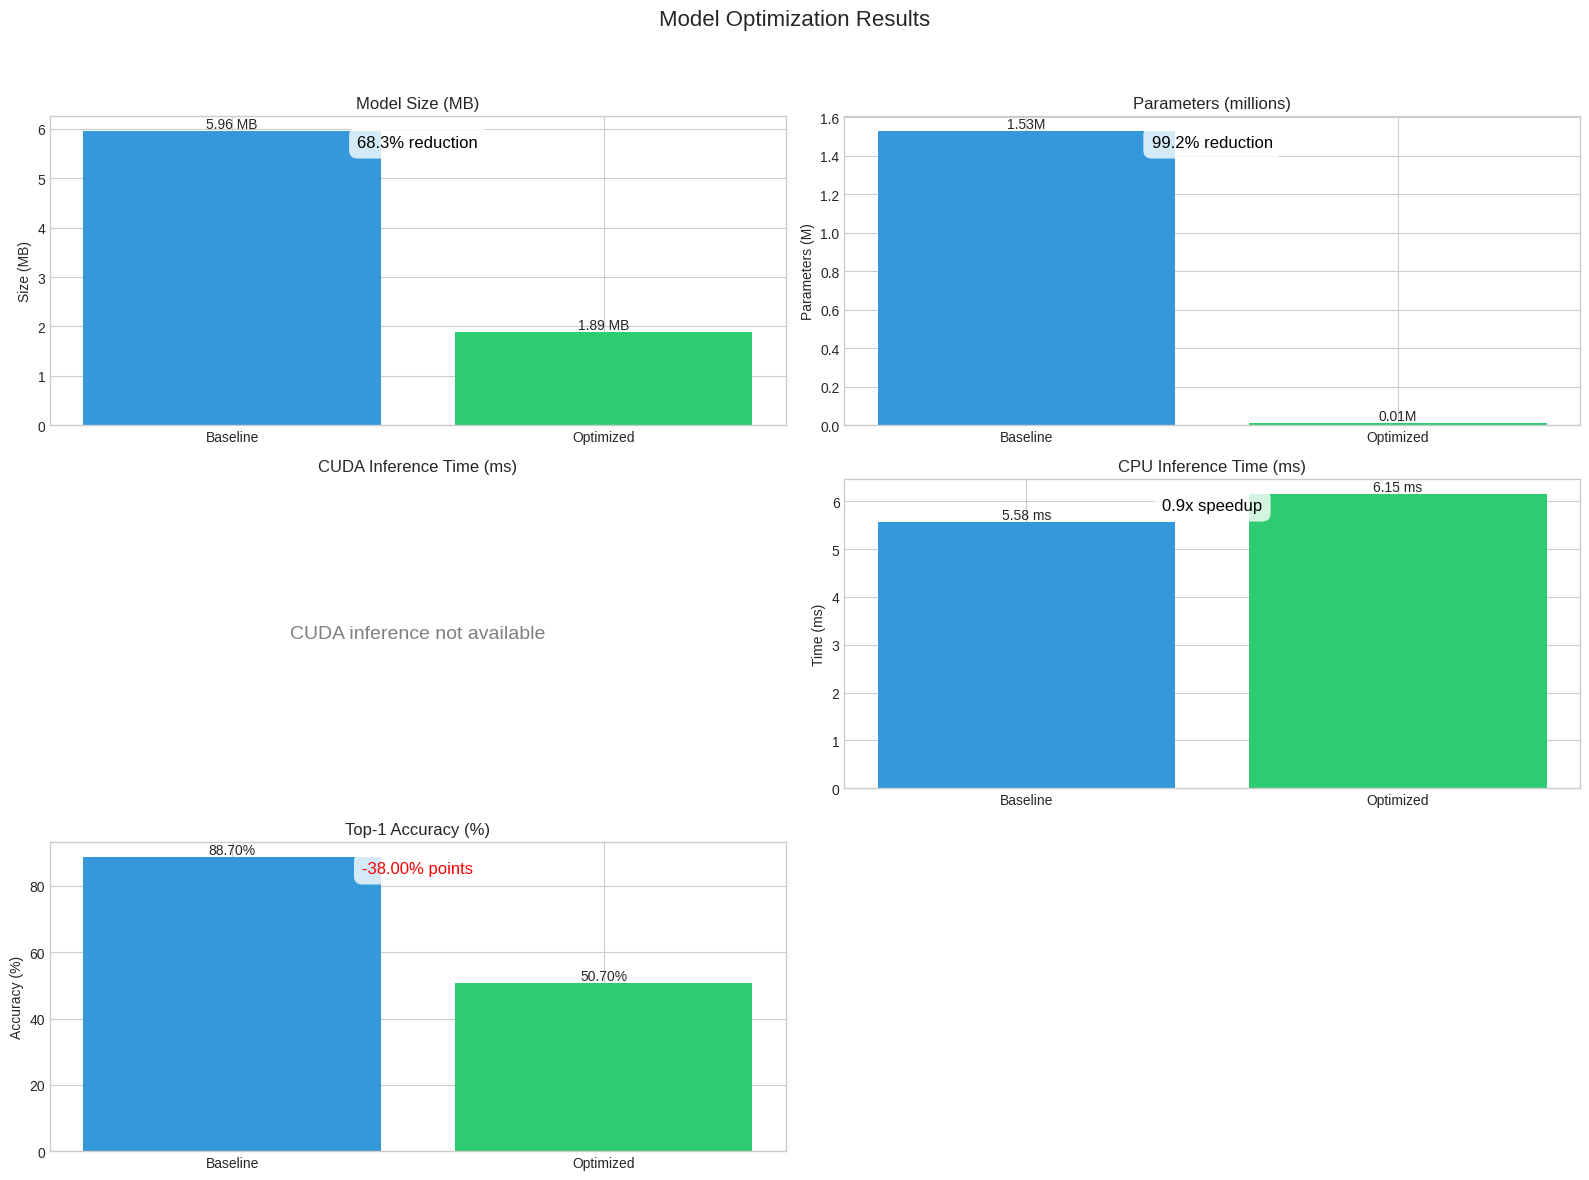


in_training/quantization/epochs10_start3 Results:
Model Size: 1.89 MB (68.3% reduction)
Parameters: 12,112 (99.2% reduction)
CPU Inference Time: 6.15 ms (0.9x speedup)
Accuracy: 50.70% (-38.00% change)
Requirements met: False


In [10]:
# Define a function to apply quantization-aware training and evaluate results
def apply_quantization_aware_training(model, config, backend):
    """
    Apply quantization-aware training to a model.
    
    Args:
        model: The model architecture to quantize
        config: Dictionary containing the training configuration for the experiment
        backend: Backend for quantization ("fbgemm" for x86 or "qnnpack" for ARM)
        
    Returns:
        Tuple of (optimized_model, comparison_results, experiment_name)
    """
    # Extract relevant training parameters for logging
    qat_start_epoch, num_epochs = config['qat_start_epoch'], config['num_epochs']
    
    # Define unique experiment name given main parameters
    experiment_name = f"in_training/quantization/epochs{num_epochs}_start{qat_start_epoch}"
    experiment_name = experiment_name.replace('.', '-')
    
    # Create experiment subdirectories
    os.makedirs(f"../models/{experiment_name}", exist_ok=True)
    os.makedirs(f"../results/{experiment_name}", exist_ok=True)
    
    print(f"Applying quantization-aware training with QAT starting at epoch {qat_start_epoch} / ending at {num_epochs}")
        
    # Move model to specified device
    model = model.to(config['device'])
    
    # Train with QAT
    # TODO: IMPLEMENT THIS FUNCTION IN THE compression/ FOLDER   
    quantized_model, qat_stats, qat_best_accuracy, qat_best_epoch = train_model_qat(
        model,
        train_loader,
        test_loader,
        config,
        checkpoint_path=f"{os.getcwd()}/../models/{experiment_name}/checkpoints",  # Providing full path to manage different sub-directory depths in utility scripts
        backend=backend,
    )
    
    # Save training statistics
    with open(f"../results/{experiment_name}/training_stats.json", 'w') as f:
        json.dump(qat_stats, f, indent=4)
    
    # Save the quantized model
    save_model(quantized_model, f"../models/{experiment_name}/model.pth")
    
    # Check that model is indeed quantized
    is_quantized(quantized_model)
    
    # Evaluate quantized model
    metrics, confusion_matrix = evaluate_optimized_model(
        quantized_model, 
        test_loader, 
        experiment_name,
        class_names,
        input_size,
        is_in_training_technique=True,
        training_stats=qat_stats,
        device=config["device_for_inference"],
    )
    
    # Compare with baseline model for performance differences
    comparison_results = compare_optimized_model_to_baseline(
        baseline_model,
        quantized_model,
        experiment_name,
        test_loader,
        class_names,
        device=config["device_for_inference"],
    )
    
    return quantized_model, comparison_results, experiment_name

#### Apply quantization-aware training
## Find info at https://pytorch.org/docs/stable/quantization.html

## Create quantizable model version
## TODO: Check the model implementation in the `compression/` folder
model = QuantizableMobileNetV3_Household(quantize=False)
    
## TODO: Experiment with different configurations
## We recommend testing testing with various start and freeze epochs
## Feel free to add more configuration parameters (and update the script in `compression/` folder accordingly)
config = {
    'qat_start_epoch': 3,  # Integer - start quantization-aware training after 3 epochs
    'freeze_bn_epochs': 6,  # Integer - freeze batch norm at epoch 6
    'num_epochs': 10,  # Integer
    'criterion': nn.CrossEntropyLoss(),  # A PyTorch loss
    'optimizer': optim.Adam(model.parameters(), lr=0.001),  # A PyTorch optimizer
    'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optim.Adam(model.parameters(), lr=0.001), patience=3),  # A PyTorch scheduler
    'patience': 5,  # Integer - early stopping patience
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),  # Use GPU for training if available
    'device_for_inference': torch.device('cpu'),  # Quantized models MUST run on CPU (PyTorch limitation)
    'grad_clip_norm': 1.0,  # Float - gradient clipping
}
backend = "fbgemm"  # One of "fbgemm" (x86/Intel/AMD) or "qnnpack" (ARM)

# Optimize and evaluate model
qat_model, qat_comparison_results, experiment_name = apply_quantization_aware_training(model, config, backend)

#### 4.3 Post-training - Pruning

Pruning reduces model size by removing weights with small magnitudes that contribute less to the output.

Applying post-training pruning with method l1_unstructured and amount 0.30
Pruning 54 modules with method: l1_unstructured, amount: 0.3
Initial model sparsity: 0.00%
Applying L1 unstructured pruning with amount=0.3
✅ Model is pruned
Final model sparsity: 29.92%
Making pruning permanent...
Model saved to ../models/post_training/pruning/l1_unstructured_0-3_cuda/model.pth

Evaluating performance of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:00<00:00, 34.63it/s]


Baseline metrics saved at ../results/post_training/pruning/l1_unstructured_0-3_cuda/metrics.json.


Calculating confusion matrix: 100%|██████████| 8/8 [00:00<00:00, 36.78it/s]


Confusion matrix saved to ../results/post_training/pruning/l1_unstructured_0-3_cuda/confusion_matrix.png


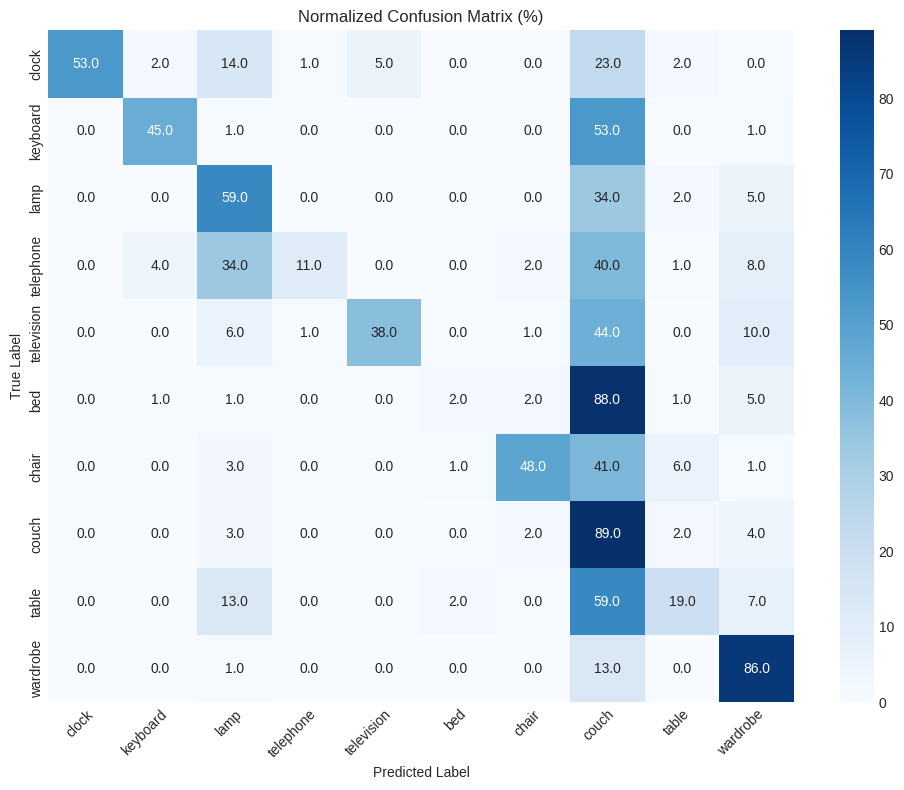


Optimized Model Metrics (post_training/pruning/l1_unstructured_0-3_cuda):
Accuracy: 45.00%
Model Size: 5.96 MB
CPU Inference Time: 5.43 ms (184.23 FPS)
CUDA Inference Time: 3.58 ms (279.16 FPS)

Comparing performance of optimized model against baseline...
Get metrics of baseline model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:00<00:00, 33.75it/s]


Get metrics of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:00<00:00, 28.55it/s]


Model comparison plot saved to ../results/post_training/pruning/l1_unstructured_0-3_cuda/comparison.png


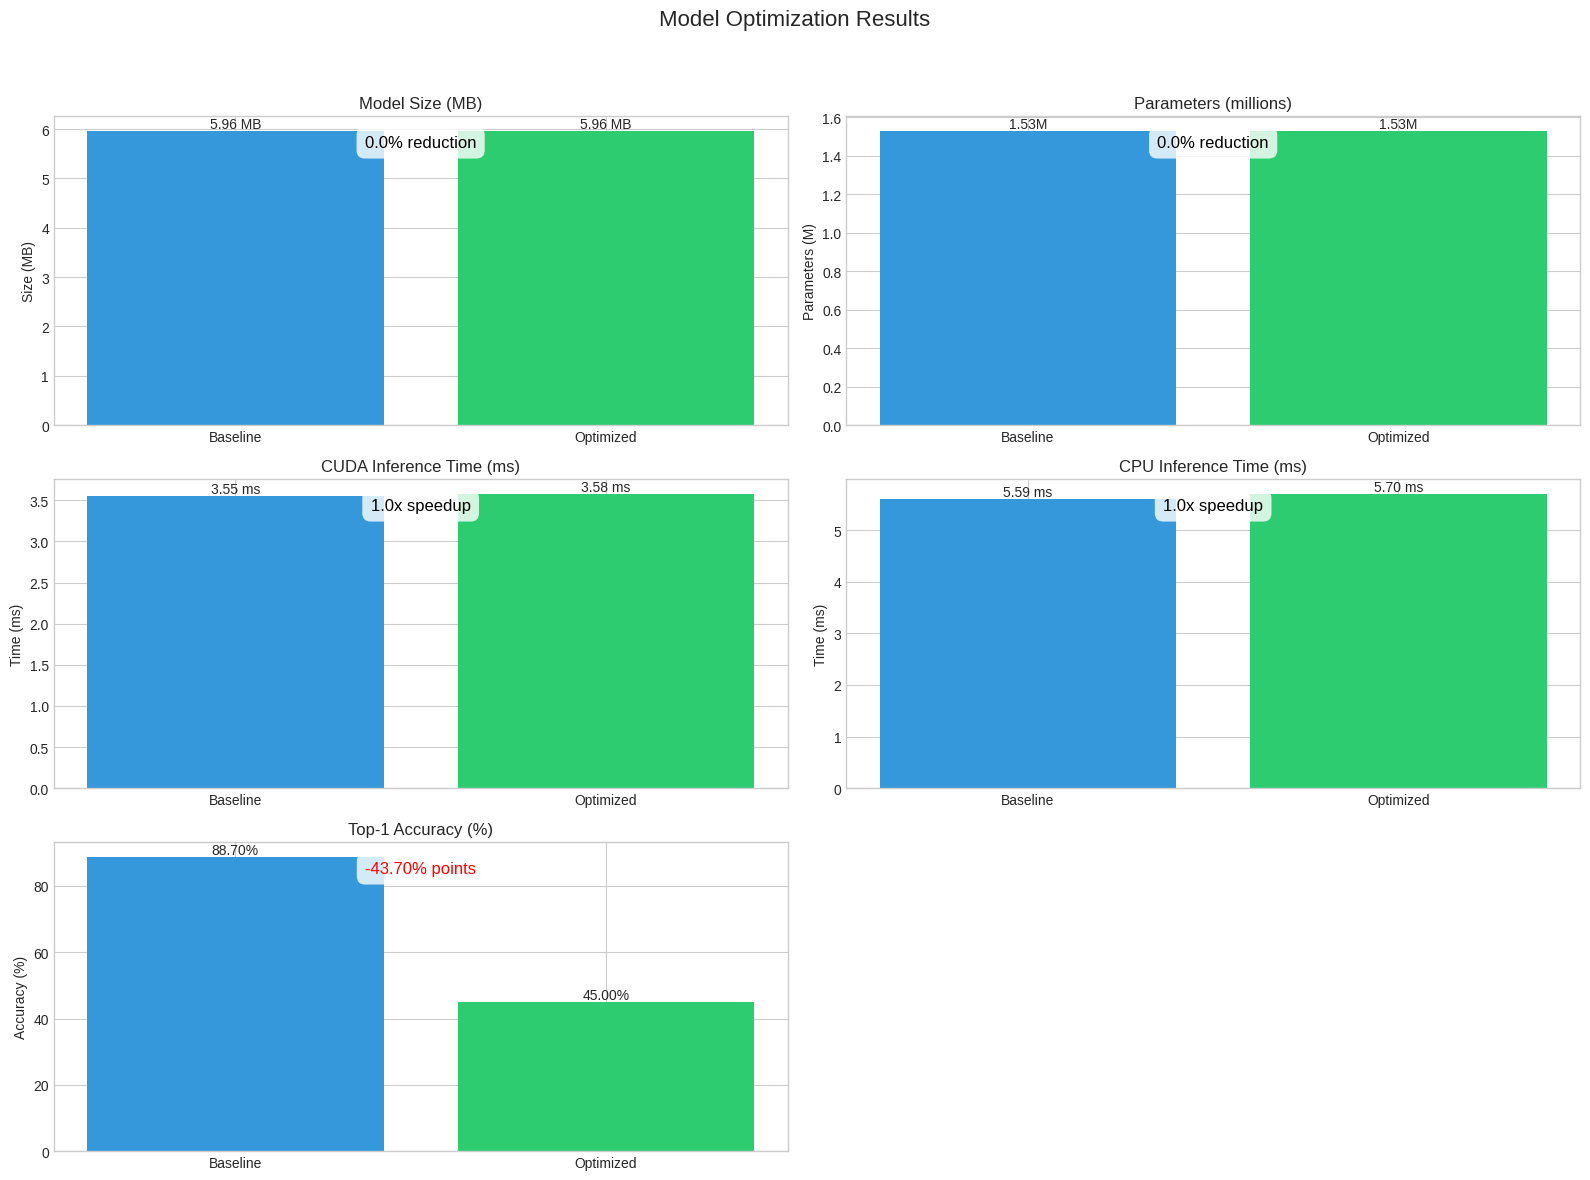


post_training/pruning/l1_unstructured_0-3_cuda Results:
Model Size: 5.96 MB (0.0% reduction)
Parameters: 1,528,106 (0.0% reduction)
CPU Inference Time: 5.70 ms (1.0x speedup)
CUDA Inference Time: 3.58 ms (1.0x speedup)
Accuracy: 45.00% (-43.70% change)
Requirements met: False


In [11]:
# Define a function to apply pruning and evaluate results
def apply_post_training_pruning(config):
    """
    Apply post-training pruning to a model with given pruning method and amount
    """
    # Extract configuration parameters
    pruning_method = config['pruning_method']
    amount = config['amount']
    device = config['device']

    # Define unique experiment name given main parameters
    experiment_name = f"post_training/pruning/{pruning_method}_{amount}_{device}"
    experiment_name = experiment_name.replace('.', '-')
    
    # Create experiment subdirectories
    os.makedirs(f"../models/{experiment_name}", exist_ok=True)
    os.makedirs(f"../results/{experiment_name}", exist_ok=True)
    
    print(f"Applying post-training pruning with method {pruning_method} and amount {amount:.2f}")
    
    # Make a copy of the baseline model and move to specified device
    orig_model = load_model(f"../models/{baseline_model_name}/checkpoints/model.pth").to(device)
    orig_model.eval()
    
    # Apply post-training pruning
    # TODO: IMPLEMENT THIS FUNCTION IN THE compression/ FOLDER 
    pruned_model = prune_model(orig_model, pruning_method, amount, config["modules_to_prune"], config["custom_pruning_fn"])
    
    # Save the pruned model
    save_model(pruned_model, f"../models/{experiment_name}/model.pth")
    
    # Evaluate pruned model
    metrics, confusion_matrix = evaluate_optimized_model(
        pruned_model, 
        test_loader, 
        experiment_name,
        class_names,
        input_size,
        device=device,
    )
    
    # Compare with baseline model for performance differences
    comparison_results = compare_optimized_model_to_baseline(
        baseline_model,
        pruned_model,
        experiment_name,
        test_loader,
        class_names,
        device=device,
    )
    
    return pruned_model, comparison_results, experiment_name


# Apply post-training pruning    
## Find info at https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

## TODO: Experiment with different configurations
## We recommend testing pruning with various ratios
## Feel free to add more configuration parameters (and update the script in `compression/` folder accordingly)
config = {
    'pruning_method': 'l1_unstructured',  # String - 'l1_unstructured', 'random_unstructured', or 'ln_structured'
    'amount': 0.3,  # Float - prune 30% of weights (0.0-1.0)
    'modules_to_prune': None,  # (Optional) List - None will prune all Conv2d and Linear layers
    'n': None,  # (Optional: Used for ln_structured pruning) Int
    'dim': None,  # Optional: Used for ln_structured pruning) Int
    'custom_pruning_fn': None,  # (Optional) Fn
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),  # Use GPU for faster processing
}

# Optimize and evaluate model
pruned_model, pruned_results, experiment_name = apply_post_training_pruning(config)

#### 4.4 In-training - Pruning

Gradual pruning progressively prunes weights during training, allowing the model to adapt to increasing sparsity.

Applying gradual pruning from 0.0% to 50.0% sparsity
Total parameters: 1,528,106
Training with gradual pruning for 10 epochs
Pruning schedule: 0.00% → 50.00% sparsity from epoch 2 to 8


Epoch 1/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s, loss=1.44, acc=63.2]


Epoch 1/10 - Train Loss: 1.0394, Train Acc: 64.80%, Test Loss: 1.4444, Test Acc: 63.20%, Sparsity: 0.00%, LR: 0.001000, Time: 62.46s


Epoch 2/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.24it/s, loss=0.874, acc=74.7]


Epoch 2/10 - Train Loss: 0.4670, Train Acc: 84.14%, Test Loss: 0.8737, Test Acc: 74.70%, Sparsity: 0.00%, LR: 0.001000, Time: 62.31s

Applying pruning to target sparsity: 0.00%


Epoch 3/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=1.11, acc=70]   


Epoch 3/10 - Train Loss: 0.3012, Train Acc: 89.46%, Test Loss: 1.1135, Test Acc: 70.00%, Sparsity: 0.00%, LR: 0.001000, Time: 62.43s

Applying pruning to target sparsity: 8.33%


Epoch 4/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s, loss=0.717, acc=81.2]


Epoch 4/10 - Train Loss: 0.2107, Train Acc: 93.22%, Test Loss: 0.7171, Test Acc: 81.20%, Sparsity: 8.31%, LR: 0.001000, Time: 62.26s
New best pruned model! Saving... (81.20%)
Model saved to ../models/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/model.pth

Applying pruning to target sparsity: 16.67%


Epoch 5/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s, loss=0.812, acc=78.5]


Epoch 5/10 - Train Loss: 0.1579, Train Acc: 94.80%, Test Loss: 0.8122, Test Acc: 78.50%, Sparsity: 23.55%, LR: 0.001000, Time: 61.72s

Applying pruning to target sparsity: 25.00%


Epoch 6/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s, loss=1.32, acc=67.7]


Epoch 6/10 - Train Loss: 0.2313, Train Acc: 92.44%, Test Loss: 1.3224, Test Acc: 67.70%, Sparsity: 42.60%, LR: 0.001000, Time: 62.55s

Applying pruning to target sparsity: 33.33%


Epoch 7/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=5.31, acc=10]  


Epoch 7/10 - Train Loss: 0.5896, Train Acc: 80.10%, Test Loss: 5.3086, Test Acc: 10.00%, Sparsity: 61.65%, LR: 0.001000, Time: 62.55s

Applying pruning to target sparsity: 41.67%


Epoch 8/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=4.57, acc=10]  


Epoch 8/10 - Train Loss: 1.5838, Train Acc: 46.60%, Test Loss: 4.5672, Test Acc: 10.00%, Sparsity: 77.52%, LR: 0.001000, Time: 62.25s

Applying pruning to target sparsity: 50.00%


Epoch 9/10 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.02it/s, loss=2.57, acc=10]  


Epoch 9/10 - Train Loss: 2.3437, Train Acc: 9.52%, Test Loss: 2.5743, Test Acc: 10.00%, Sparsity: 88.63%, LR: 0.001000, Time: 62.43s
Early stopping at epoch 9. No improvement for 5 epochs.
Making pruning permanent on best model...
✅ Model is pruned
Model saved to ../models/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/model.pth
Training completed. Best accuracy: 81.20%
Best model saved as '../models/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/model.pth' at epoch 4
Final model sparsity: 8.31%
Model saved to ../models/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/model.pth

Evaluating performance of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


Baseline metrics saved at ../results/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/metrics.json.


Calculating confusion matrix: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Confusion matrix saved to ../results/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/confusion_matrix.png


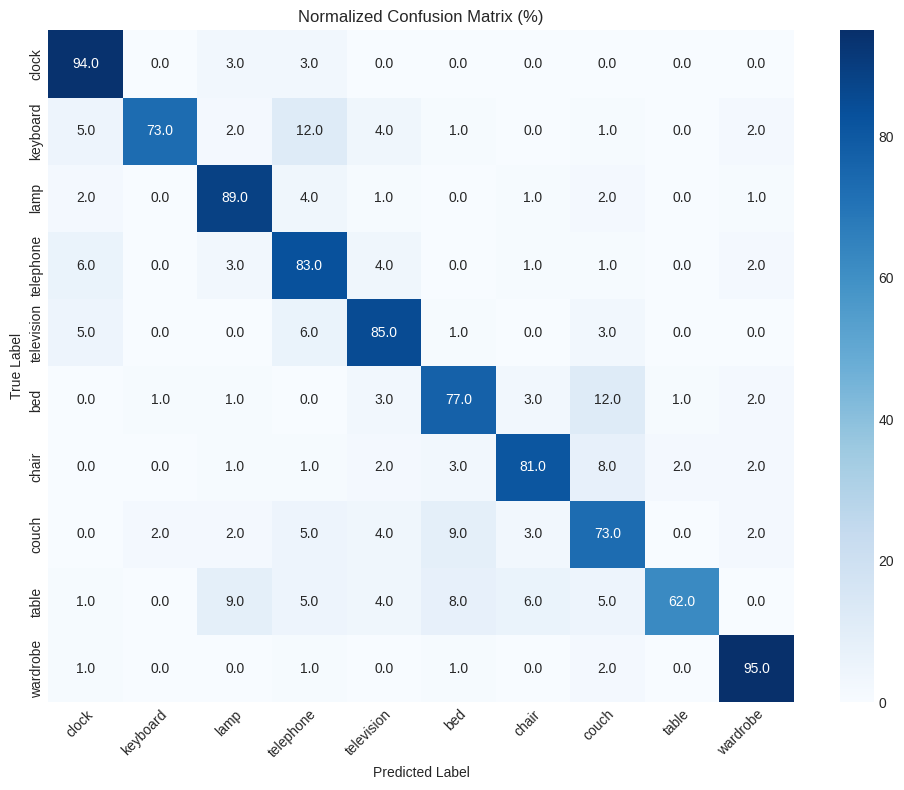

Weight distribution plot saved to ../results/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/weight_distribution.png


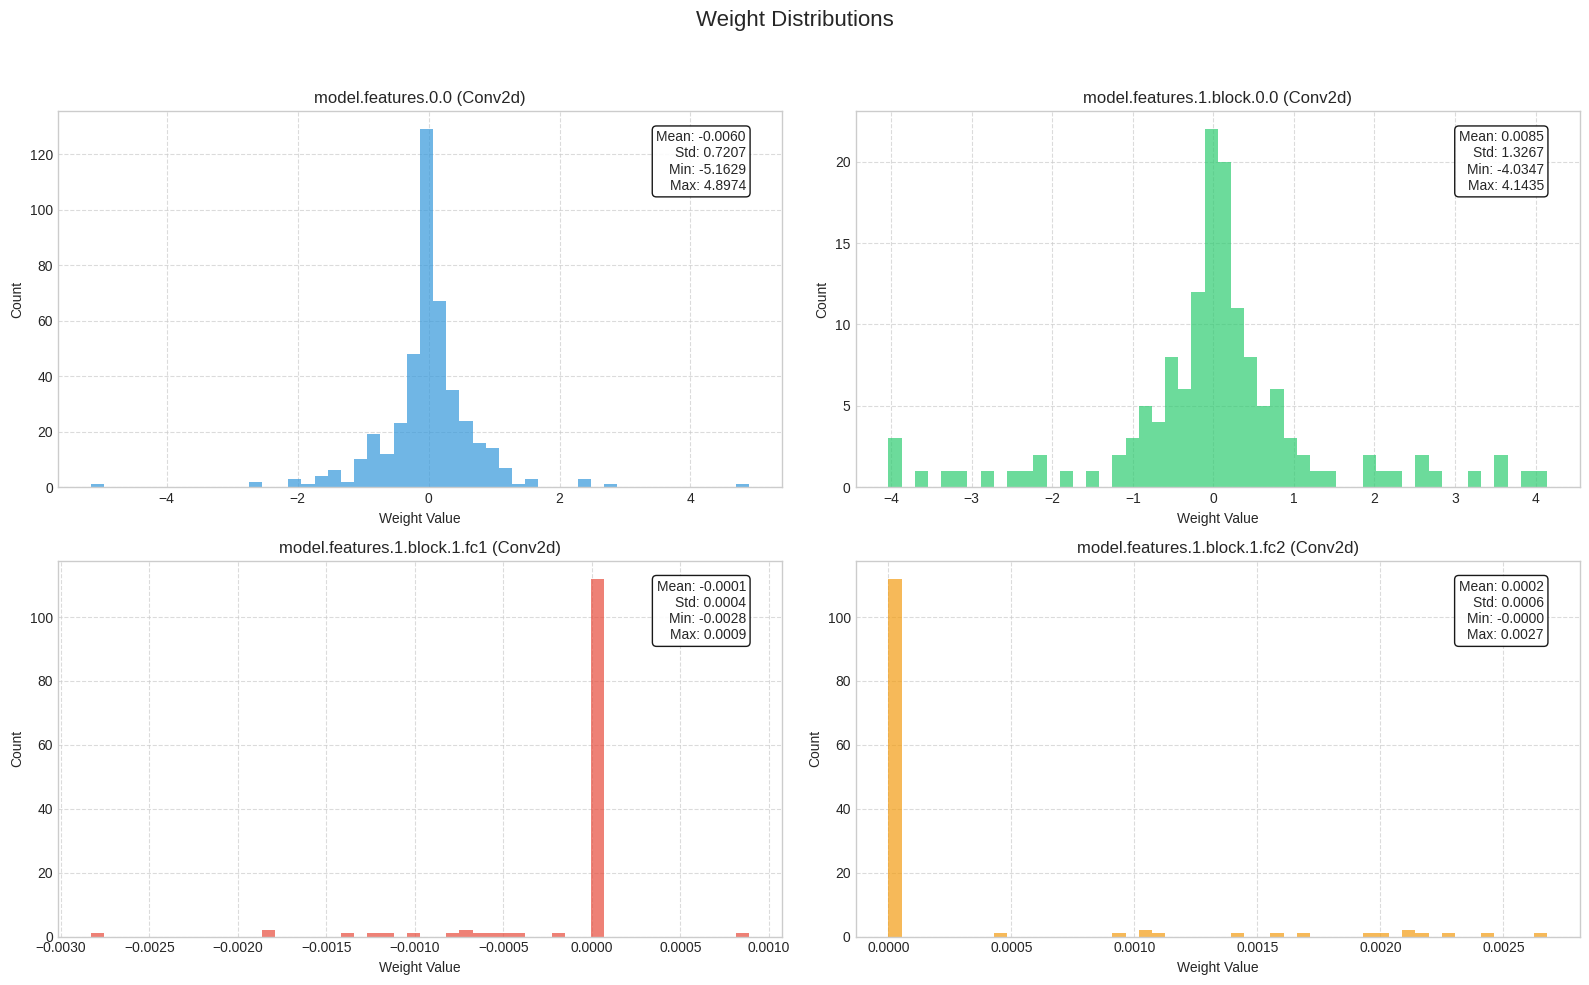

Training history plot saved to ../results/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/training_history.png


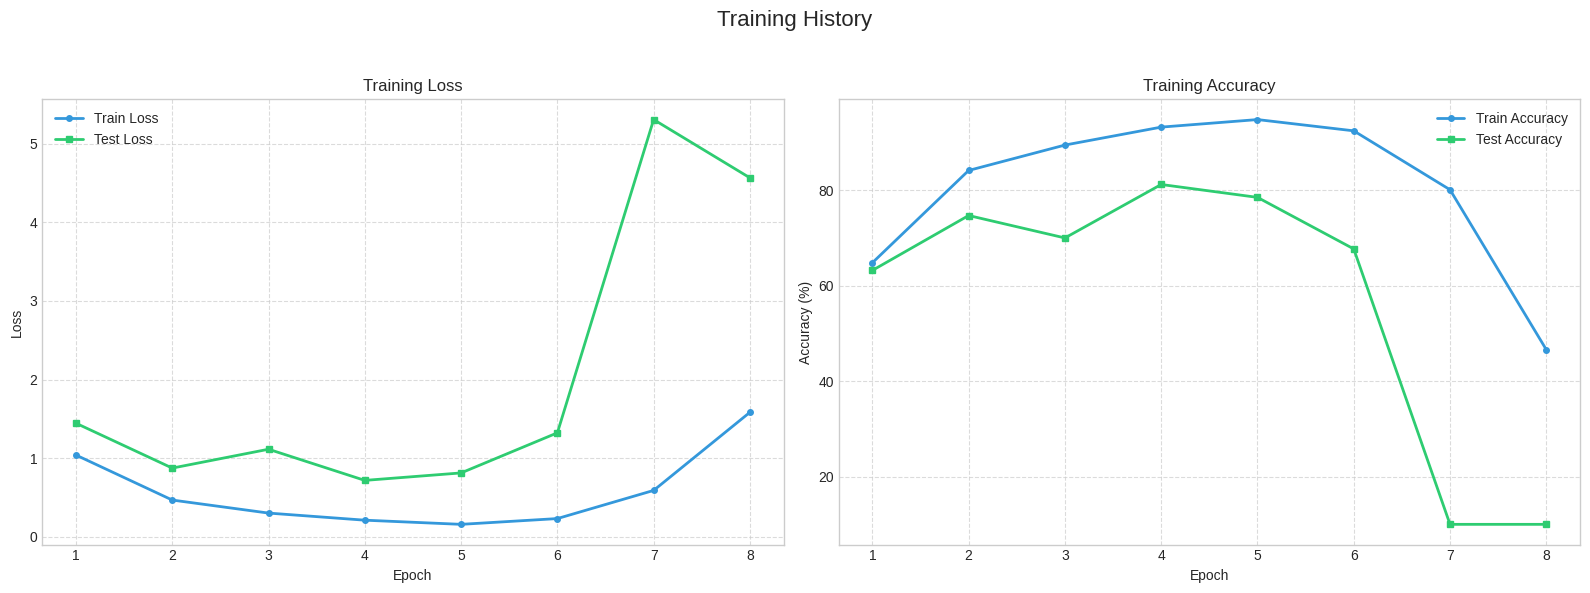


Optimized Model Metrics (in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8):
Accuracy: 81.20%
Model Size: 5.96 MB
CPU Inference Time: 6.66 ms (150.21 FPS)

Comparing performance of optimized model against baseline...
Get metrics of baseline model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Get metrics of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


Model comparison plot saved to ../results/in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8/comparison.png


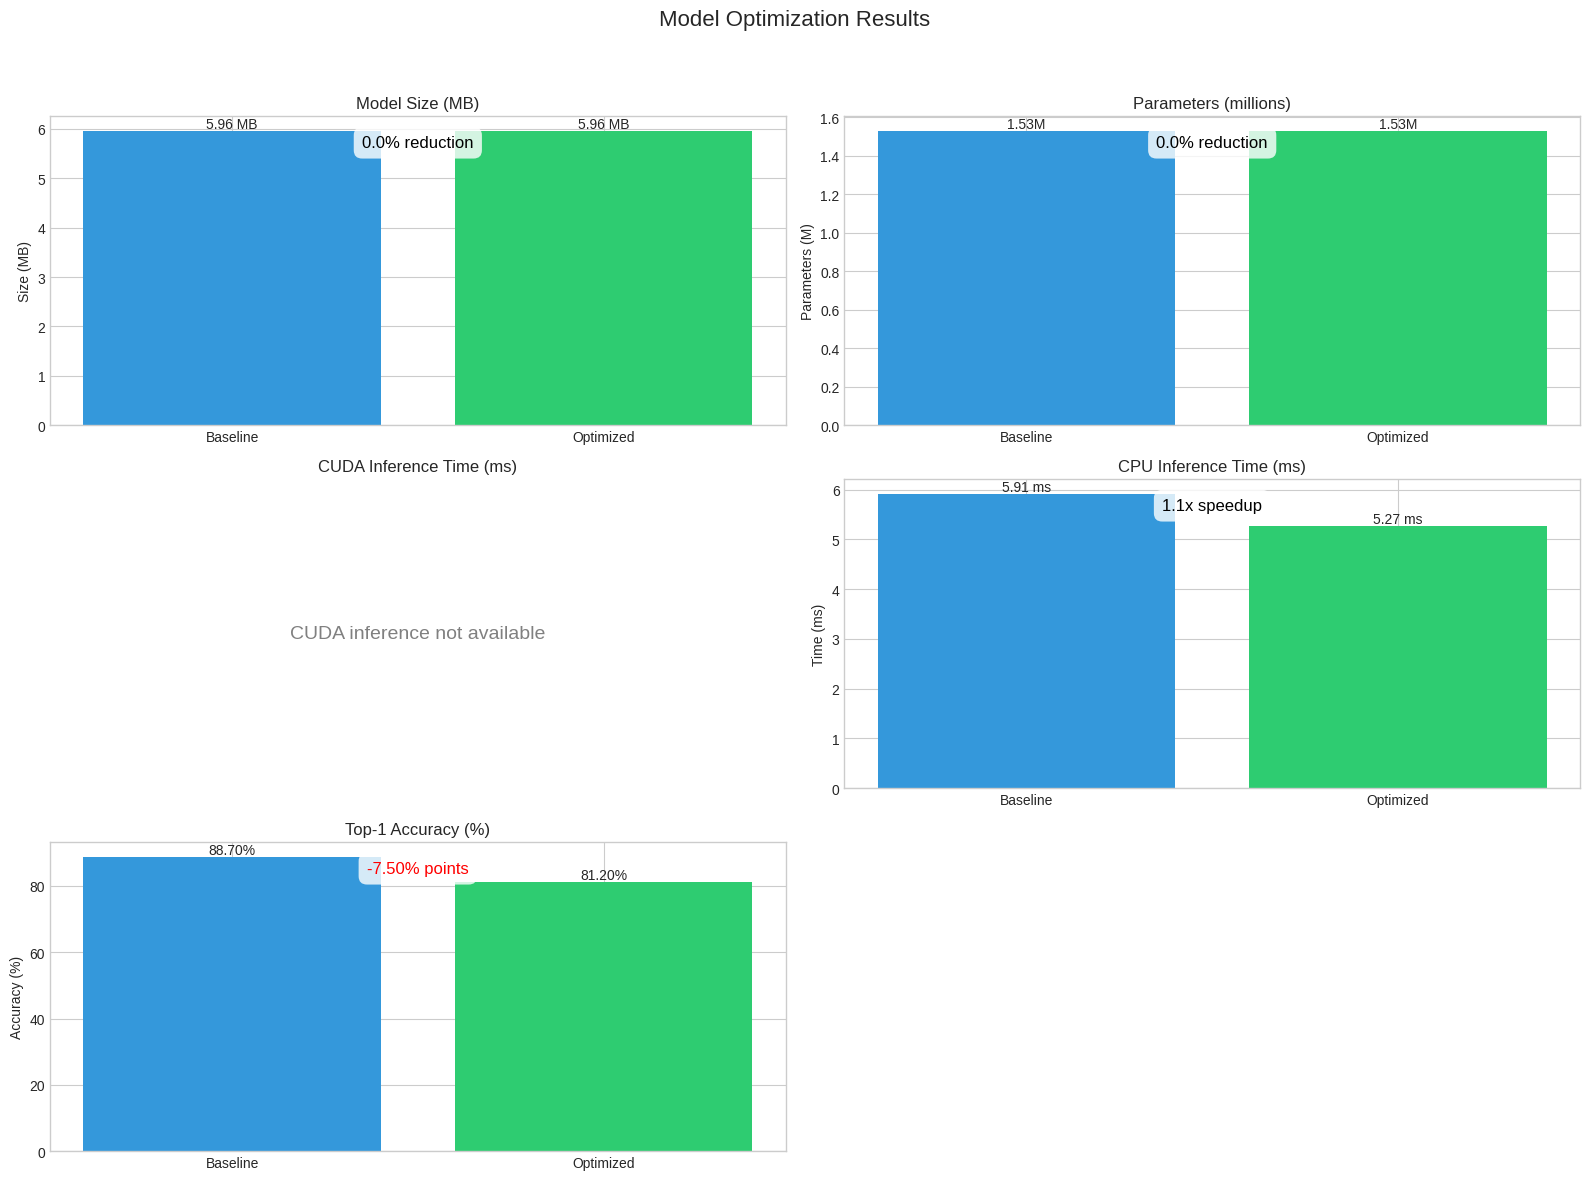


in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8 Results:
Model Size: 5.96 MB (0.0% reduction)
Parameters: 1,528,106 (0.0% reduction)
CPU Inference Time: 5.27 ms (1.1x speedup)
Accuracy: 81.20% (-7.50% change)
Requirements met: False


In [12]:
# Define a function to apply pruning during training and evaluate results
def apply_in_training_pruning(model, config):
    """
    Apply gradual pruning during training.
    
    Args:
        model: The model architecture to quantize
        config: Dictionary containing the training configuration for the experiment
        
    Returns:
        Tuple of (optimized_model, comparison_results, experiment_name)
    """
    # Extract relevant training parameters for logging
    pruning_method, initial_sparsity, final_sparsity = config['pruning_method'], config['initial_sparsity'], config['final_sparsity'] 
    start_epoch, end_epoch = config['start_epoch'], config['end_epoch'] 
    device = config['device']
    
    # Define unique experiment name given main parameters
    experiment_name = f"in_training/pruning/{pruning_method}_sparsity{initial_sparsity}-{final_sparsity}_epochs{start_epoch}-{end_epoch}"
    experiment_name = experiment_name.replace('.', '-')
    
    # Create experiment subdirectories
    os.makedirs(f"../models/{experiment_name}", exist_ok=True)
    os.makedirs(f"../results/{experiment_name}", exist_ok=True)
    
    print(f"Applying gradual pruning from {initial_sparsity:.1%} to {final_sparsity:.1%} sparsity")
    
    # Move model to specified device
    model = model.to(device)
    
    # Train with gradual pruning
    # TODO: IMPLEMENT THIS FUNCTION IN THE compression/ FOLDER 
    pruned_model, pruning_stats, pruned_best_accuracy, pruned_best_epoch = train_with_pruning(
        model,
        train_loader,
        test_loader,
        config,
        checkpoint_path=f"../models/{experiment_name}/model.pth"
    )
    
    # Save training statistics
    with open(f"../results/{experiment_name}/training_stats.json", 'w') as f:
        json.dump(pruning_stats, f, indent=4)
    
    # Save the quantized model
    save_model(pruned_model, f"../models/{experiment_name}/model.pth")
    
    # Evaluate quantized model
    metrics, confusion_matrix = evaluate_optimized_model(
        pruned_model, 
        test_loader, 
        experiment_name,
        class_names,
        input_size,
        is_in_training_technique=True,
        training_stats=pruning_stats,
        device=device,
    )
    
    # Compare with baseline model for performance differences
    comparison_results = compare_optimized_model_to_baseline(
        baseline_model,
        pruned_model,
        experiment_name,
        test_loader,
        class_names,
        device=device,
    )
    return pruned_model, comparison_results, experiment_name

# Apply in-training pruning 
## Find info at https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

## Create a new model instance
model = MobileNetV3_Household()

## TODO: Experiment with different configurations
# We recommend testing pruning with various sparsity and epochs settings
## Feel free to add more configuration parameters (and update the script in `compression/` folder accordingly)
config = {
    # General training config
    'num_epochs': 10,  # Integer
    'criterion': nn.CrossEntropyLoss(),  # A PyTorch loss  
    'optimizer': optim.Adam(model.parameters(), lr=0.001),  # A PyTorch optimizer   
    'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optim.Adam(model.parameters(), lr=0.001), patience=3),  # A PyTorch scheduler
    'patience': 5,  # Integer - early stopping patience
    'device': torch.device('cpu'),  # Define with torch.device()
    'grad_clip_norm': 1.0,  # Float - gradient clipping
    # Pruning-specific config
    'initial_sparsity': 0.0,  # Float - start with no pruning
    'final_sparsity': 0.5,    # Float - end with 50% sparsity
    'start_epoch': 2,  # Integer - start pruning after 2 epochs
    'end_epoch': 8,  # Integer - finish pruning by epoch 8
    'pruning_frequency': 1,  # Integer - prune every epoch
    'pruning_method': 'l1_unstructured',  # String
    'schedule_type': 'linear',  # String - linear sparsity schedule
    'only_prune_conv': False,  # Boolean - prune all compatible layers
}
    
pruned_model, pruned_comparison_results, experiment_name = apply_in_training_pruning(model, config)

#### 4.5 In-training - Knowledge Distillation

Knowledge distillation trains a smaller student model to mimic a larger teacher model.

Applying knowledge distillation with temperature=3.0 and alpha=0.7
Student parameters: 1,077,290
Teacher parameters: 1,528,106
Training with knowledge distillation for 15 epochs
Temperature: 3.0, Alpha: 0.7


Epoch 1/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=2.45, acc=57.3]


Epoch 1/15 - Train Loss: 5.1819, Train Acc: 60.00%, Test Loss: 2.4530, Test Acc: 57.30%, LR: 0.001000, Time: 81.58s
New best student model! Saving... (57.30%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 2/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=1.23, acc=71.5]


Epoch 2/15 - Train Loss: 1.6740, Train Acc: 83.80%, Test Loss: 1.2272, Test Acc: 71.50%, LR: 0.001000, Time: 81.95s
New best student model! Saving... (71.50%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 3/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.812, acc=81.8]


Epoch 3/15 - Train Loss: 1.0736, Train Acc: 89.00%, Test Loss: 0.8116, Test Acc: 81.80%, LR: 0.001000, Time: 81.68s
New best student model! Saving... (81.80%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 4/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.05it/s, loss=0.719, acc=83]  


Epoch 4/15 - Train Loss: 0.8728, Train Acc: 91.36%, Test Loss: 0.7192, Test Acc: 83.00%, LR: 0.001000, Time: 81.95s
New best student model! Saving... (83.00%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 5/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s, loss=0.716, acc=82.6]


Epoch 5/15 - Train Loss: 0.7508, Train Acc: 93.28%, Test Loss: 0.7161, Test Acc: 82.60%, LR: 0.001000, Time: 81.88s


Epoch 6/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s, loss=0.532, acc=85.7]


Epoch 6/15 - Train Loss: 0.5988, Train Acc: 94.50%, Test Loss: 0.5321, Test Acc: 85.70%, LR: 0.001000, Time: 81.66s
New best student model! Saving... (85.70%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 7/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.526, acc=86.1]


Epoch 7/15 - Train Loss: 0.5980, Train Acc: 94.58%, Test Loss: 0.5256, Test Acc: 86.10%, LR: 0.001000, Time: 82.27s
New best student model! Saving... (86.10%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 8/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s, loss=0.556, acc=86.6]


Epoch 8/15 - Train Loss: 0.5028, Train Acc: 95.94%, Test Loss: 0.5561, Test Acc: 86.60%, LR: 0.001000, Time: 81.70s
New best student model! Saving... (86.60%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 9/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s, loss=0.591, acc=85.9]


Epoch 9/15 - Train Loss: 0.5254, Train Acc: 96.00%, Test Loss: 0.5908, Test Acc: 85.90%, LR: 0.001000, Time: 81.95s


Epoch 10/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s, loss=0.648, acc=84.2]


Epoch 10/15 - Train Loss: 0.7210, Train Acc: 94.66%, Test Loss: 0.6483, Test Acc: 84.20%, LR: 0.001000, Time: 82.62s


Epoch 11/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.54, acc=85.8] 


Epoch 11/15 - Train Loss: 0.5619, Train Acc: 95.58%, Test Loss: 0.5400, Test Acc: 85.80%, LR: 0.000100, Time: 81.87s


Epoch 12/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.04it/s, loss=0.439, acc=88.5]


Epoch 12/15 - Train Loss: 0.4133, Train Acc: 97.64%, Test Loss: 0.4392, Test Acc: 88.50%, LR: 0.000100, Time: 81.83s
New best student model! Saving... (88.50%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 13/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.4, acc=89]    


Epoch 13/15 - Train Loss: 0.3742, Train Acc: 97.78%, Test Loss: 0.4000, Test Acc: 89.00%, LR: 0.000100, Time: 81.37s
New best student model! Saving... (89.00%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 14/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s, loss=0.392, acc=90.3]


Epoch 14/15 - Train Loss: 0.3459, Train Acc: 98.04%, Test Loss: 0.3922, Test Acc: 90.30%, LR: 0.000100, Time: 81.67s
New best student model! Saving... (90.30%)
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth


Epoch 15/15 [Test]: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.378, acc=89.8]


Epoch 15/15 - Train Loss: 0.3472, Train Acc: 97.98%, Test Loss: 0.3785, Test Acc: 89.80%, LR: 0.000100, Time: 82.41s
Distillation completed. Best student accuracy: 90.30%
Best student model saved as '../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth' at epoch 14
Model saved to ../models/in_training/distillation/temp3-0_alpha0-7_epochs15/model.pth

Evaluating performance of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


Baseline metrics saved at ../results/in_training/distillation/temp3-0_alpha0-7_epochs15/metrics.json.


Calculating confusion matrix: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Confusion matrix saved to ../results/in_training/distillation/temp3-0_alpha0-7_epochs15/confusion_matrix.png


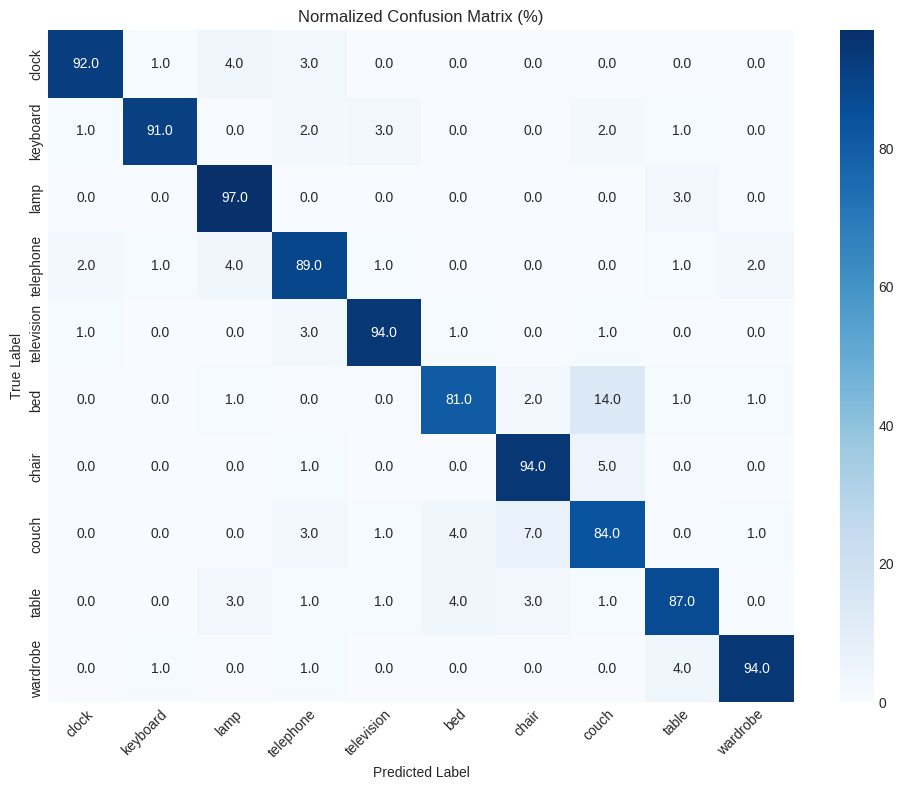

Weight distribution plot saved to ../results/in_training/distillation/temp3-0_alpha0-7_epochs15/weight_distribution.png


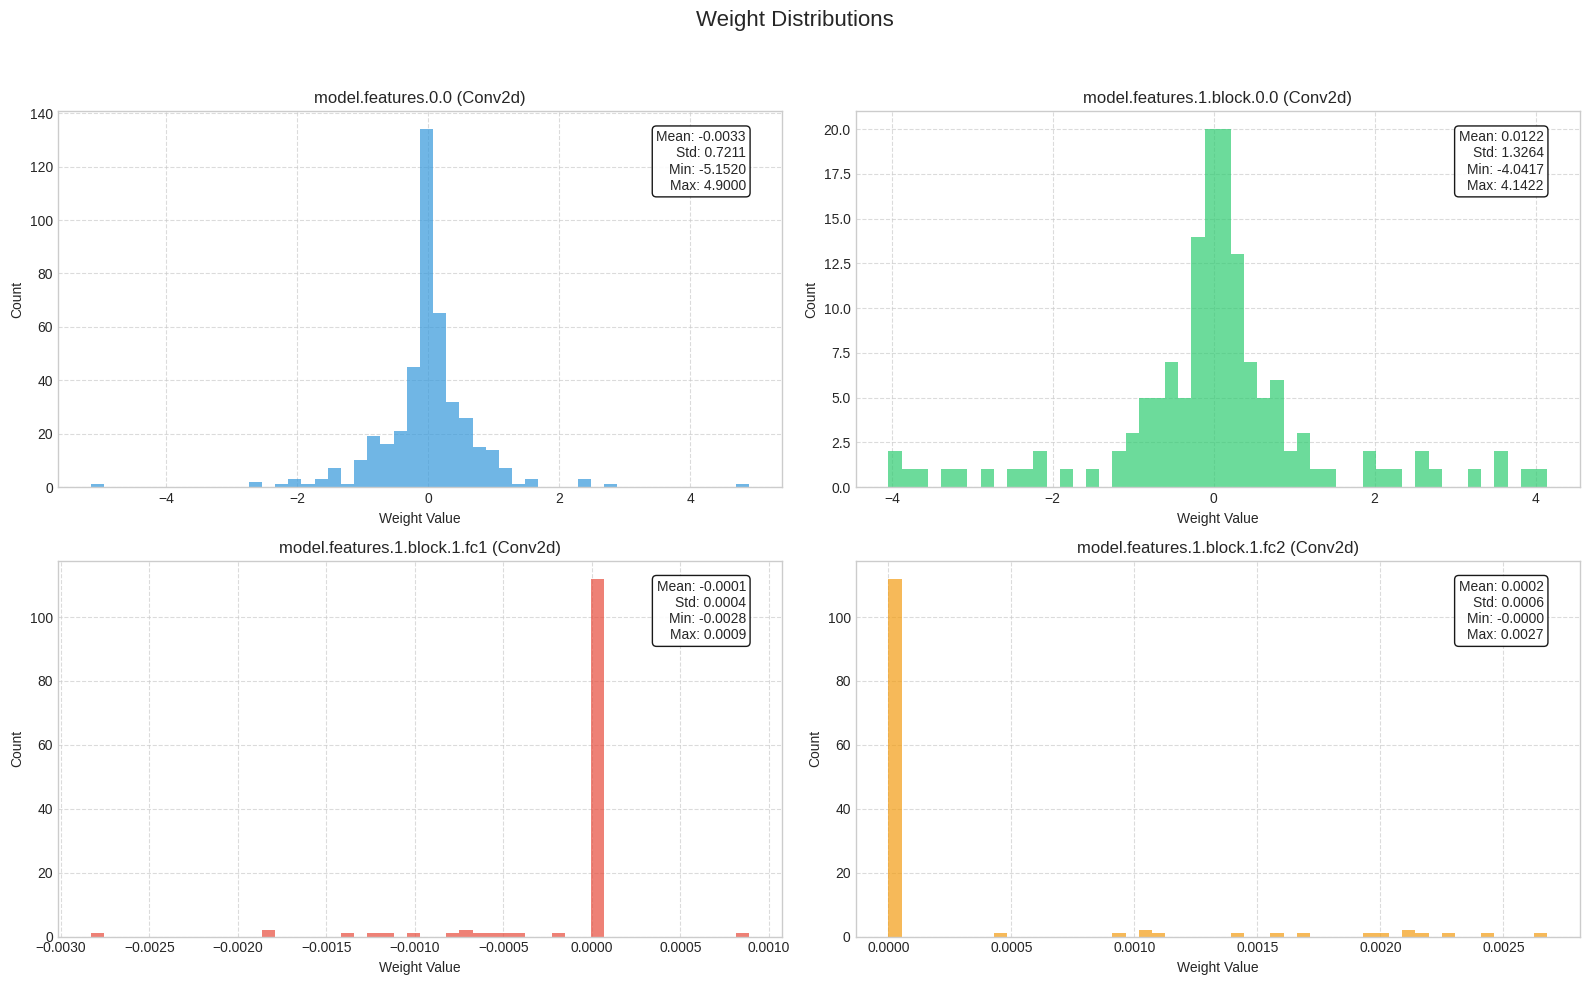

Training history plot saved to ../results/in_training/distillation/temp3-0_alpha0-7_epochs15/training_history.png


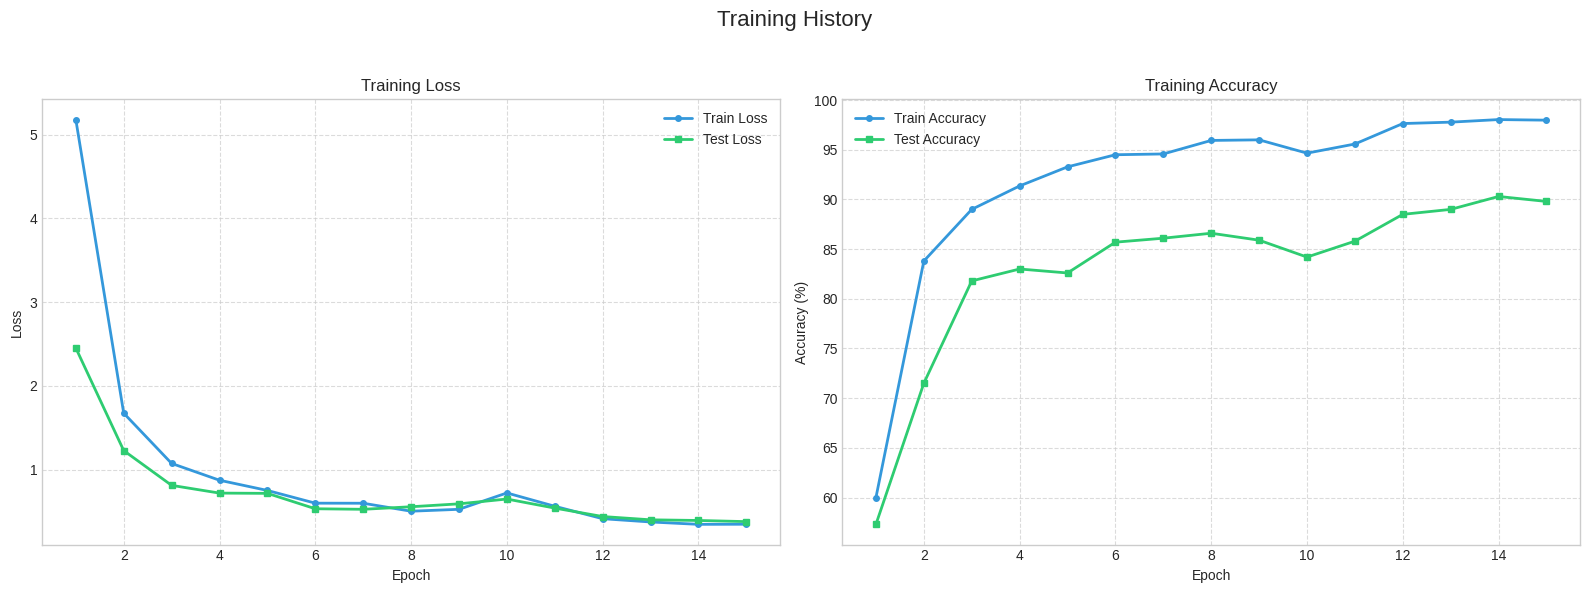


Optimized Model Metrics (in_training/distillation/temp3-0_alpha0-7_epochs15):
Accuracy: 90.30%
Model Size: 4.24 MB
CPU Inference Time: 6.23 ms (160.45 FPS)

Comparing performance of optimized model against baseline...
Get metrics of baseline model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Get metrics of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


Model comparison plot saved to ../results/in_training/distillation/temp3-0_alpha0-7_epochs15/comparison.png


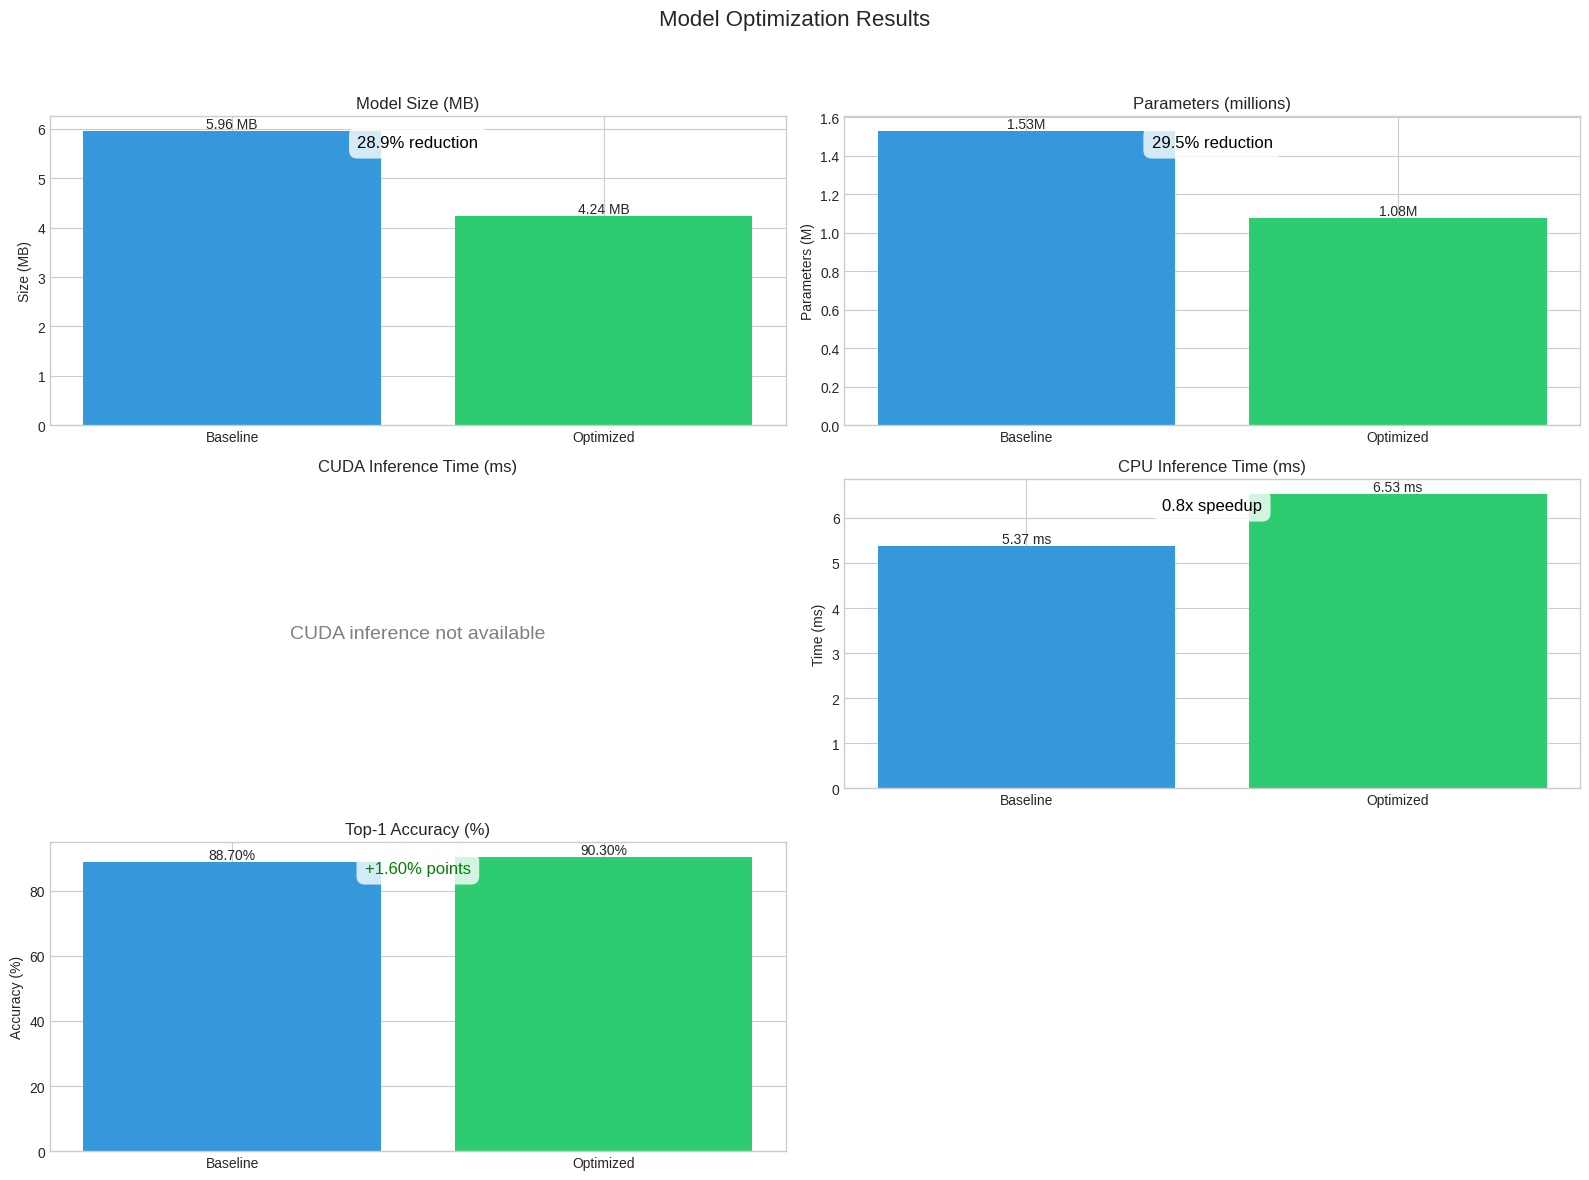


in_training/distillation/temp3-0_alpha0-7_epochs15 Results:
Model Size: 4.24 MB (28.9% reduction)
Parameters: 1,077,290 (29.5% reduction)
CPU Inference Time: 6.53 ms (0.8x speedup)
Accuracy: 90.30% (+1.60% change)
Requirements met: False


In [13]:
# Define a function to apply knowledge distillation and evaluate results
def apply_knowledge_distillation(teacher_model, student_model, config):
    """
    Apply knowledge distillation from a teacher model to a student model.
    
    Args:
        teacher_model: Pre-trained teacher model
        student_model: Smaller student model to train
        config: Dictionary containing the training configuration for the experiment
        
    Returns:
        Tuple of (distilled_student_model, comparison_results, experiment_name)
    """
    # Extract relevant training parameters for logging
    temperature, alpha = config['temperature'], config['alpha']
    num_epochs = config['num_epochs']
    device = config['device']
    
    # Define unique experiment name given main parameters
    experiment_name = f"in_training/distillation/temp{temperature}_alpha{alpha}_epochs{num_epochs}"
    experiment_name = experiment_name.replace('.', '-')
    
    # Create experiment subdirectories
    os.makedirs(f"../models/{experiment_name}", exist_ok=True)
    os.makedirs(f"../results/{experiment_name}", exist_ok=True)
    
    print(f"Applying knowledge distillation with temperature={temperature} and alpha={alpha}")
    
    # Move models to specified device
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    
    # Train student with knowledge distillation
    # TODO: IMPLEMENT THIS FUNCTION IN THE compression/ FOLDER 
    distilled_model, distillation_stats, best_accuracy, best_epoch = train_with_distillation(
        student_model,
        teacher_model,
        train_loader,
        test_loader,
        config,
        checkpoint_path=f"../models/{experiment_name}/model.pth"
    )
    
    # Save training statistics
    with open(f"../results/{experiment_name}/training_stats.json", 'w') as f:
        json.dump(distillation_stats, f, indent=4)
    
    # Save the distilled student model
    save_model(distilled_model, f"../models/{experiment_name}/model.pth")
    
    # Evaluate distilled student model
    metrics, confusion_matrix = evaluate_optimized_model(
        distilled_model, 
        test_loader, 
        experiment_name,
        class_names,
        input_size,
        is_in_training_technique=True,
        training_stats=distillation_stats,
        device=device,
    )
    
    # Compare with baseline model for performance differences
    comparison_results = compare_optimized_model_to_baseline(
        baseline_model,
        distilled_model,
        experiment_name,
        test_loader,
        class_names,
        device=device,
    )
    
    return distilled_model, comparison_results, experiment_name

# Apply knowledge distillation
## Find more info at https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html

## Load the pre-trained teacher model
teacher_model = load_model(f"../models/{baseline_model_name}/checkpoints/model.pth")
teacher_model.eval()  # Teacher should be in eval mode

## Create student model
## TODO: Check the model implementation in the `compression/` folder
student_model = MobileNetV3_Household_Small(num_classes=len(class_names))
## Uncomment print below to inspect the student model architecture
# print_model_summary(student_model)

# TODO: EXPERIMENT WITH DIFFERENT TRAINING PARAMETERS
# We recommend testing distillation with different alpha and temperature
## Feel free to add more configuration parameters (and update the script in `compression/` folder accordingly)
optimizer = optim.Adam(student_model.parameters(), lr=0.001)  # A PyTorch optimizer
config = {
    'num_epochs': 15,  # Integer - train for more epochs for distillation
    'criterion': nn.CrossEntropyLoss(),  # A PyTorch loss
    'optimizer': optimizer,  # A PyTorch optimizer
    'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3),  # A PyTorch scheduler
    'alpha': 0.7,  # Float - balance between distillation (0.7) and hard labels (0.3)
    'temperature': 3.0,  # Float - softening temperature for distillation
    'patience': 5,  # Integer - early stopping patience
    'device': torch.device('cpu'),  # Define with torch.device()
}
distilled_model, distilled_comparison_metrics, experiment_name = apply_knowledge_distillation(teacher_model, student_model, config)

#### 4.6 In-training - Graph Optimizations

Graph optimizations fuse operations and remove redundant nodes for better inference performance.

Applying optimization with torchscript as method
Tracing model with TorchScript...
Freezing model...
Optimizing TorchScript model for inference...
TorchScript optimization complete
Model saved to ../models/post_training/graph_optimization/torchscript_cuda/model.pt
Original and optimized models produce equivalent outputs.

Evaluating performance of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:00<00:00,  8.80it/s]


Baseline metrics saved at ../results/post_training/graph_optimization/torchscript_cuda/metrics.json.


Calculating confusion matrix: 100%|██████████| 8/8 [00:00<00:00, 24.01it/s]


Confusion matrix saved to ../results/post_training/graph_optimization/torchscript_cuda/confusion_matrix.png


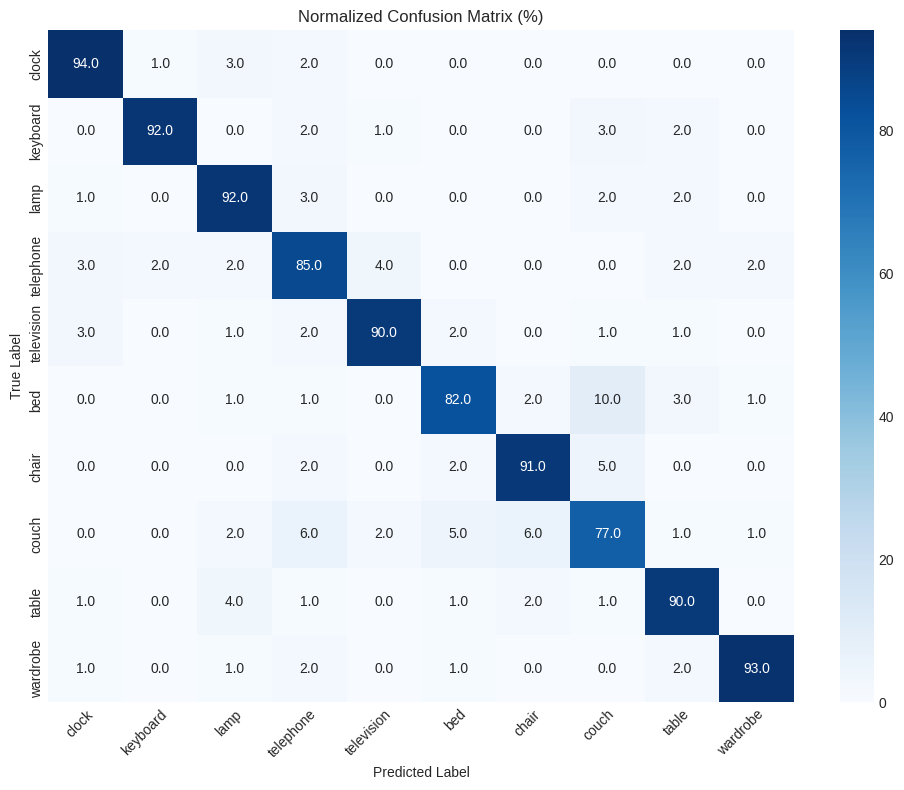


Optimized Model Metrics (post_training/graph_optimization/torchscript_cuda):
Accuracy: 88.60%
Model Size: 5.84 MB
CUDA Inference Time: 1.30 ms (768.15 FPS)

Comparing performance of optimized model against baseline...
Get metrics of baseline model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:00<00:00, 21.69it/s]


Get metrics of optimized model...


Evaluating per-class accuracy: 100%|██████████| 8/8 [00:00<00:00, 22.70it/s]


Model comparison plot saved to ../results/post_training/graph_optimization/torchscript_cuda/comparison.png


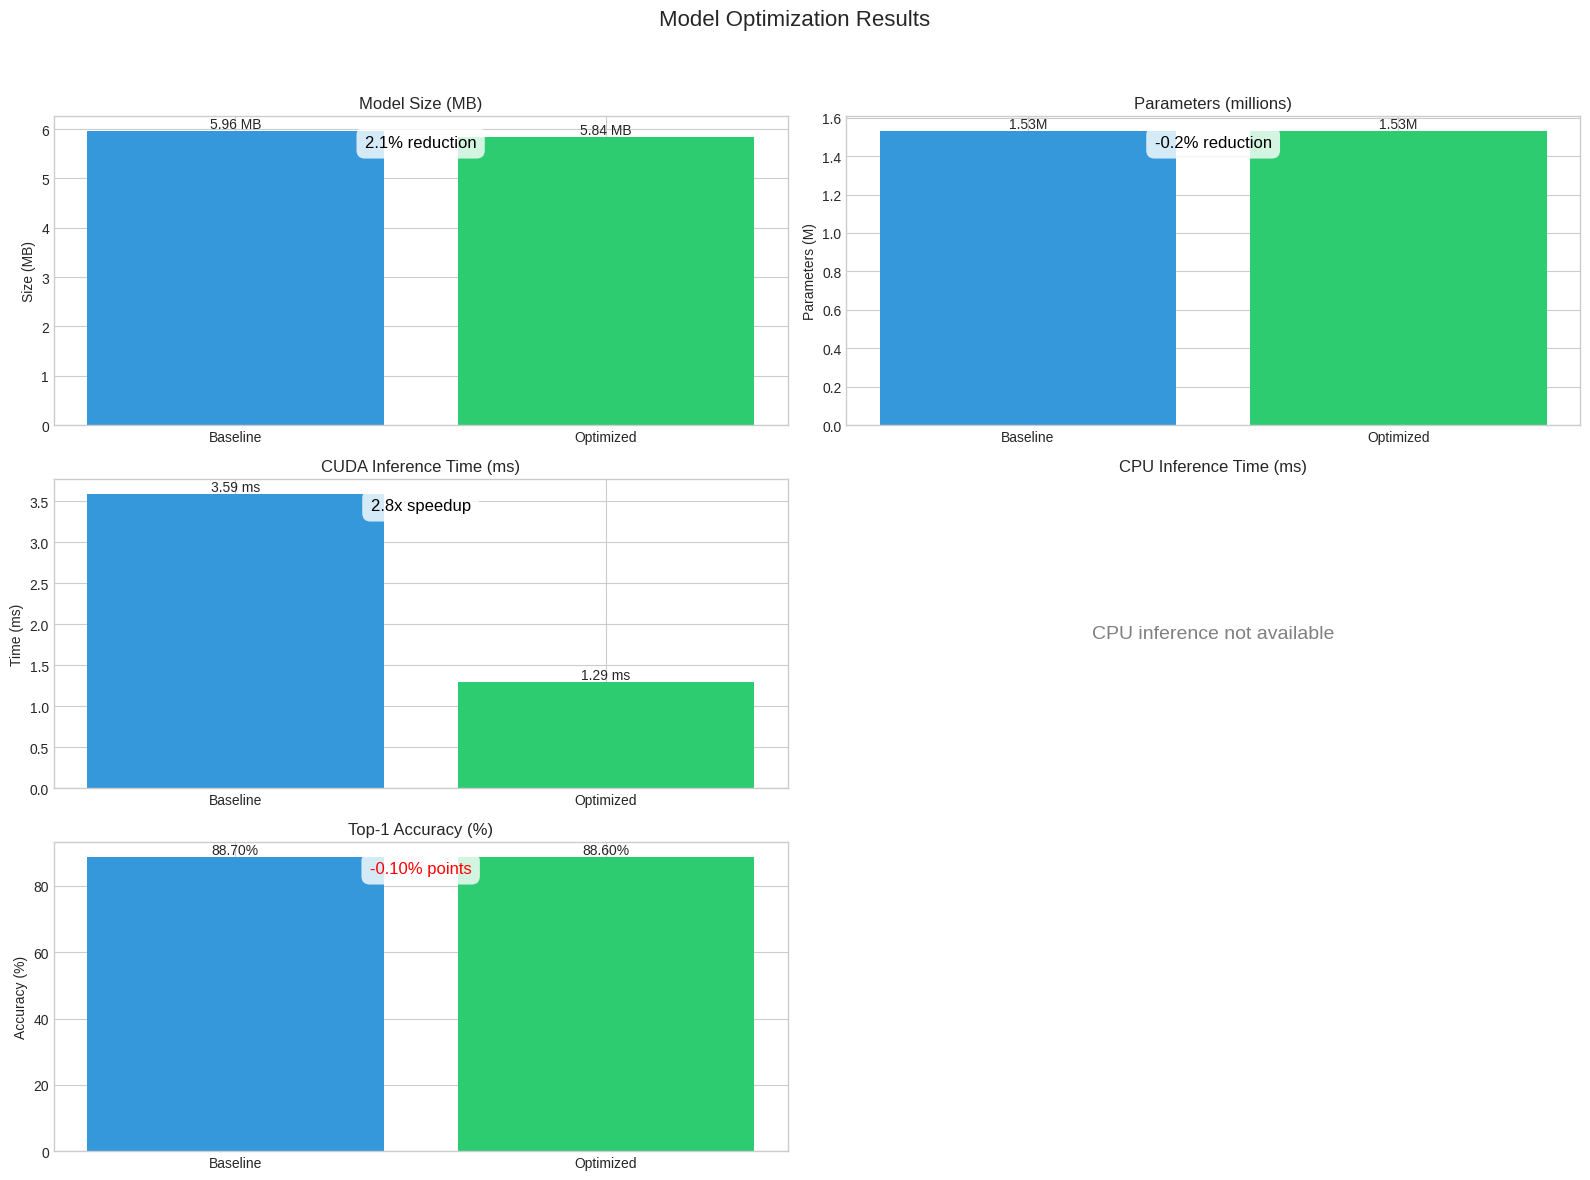


post_training/graph_optimization/torchscript_cuda Results:
Model Size: 5.84 MB (2.1% reduction)
Parameters: 1,530,400 (-0.2% reduction)
CUDA Inference Time: 1.29 ms (2.8x speedup)
Accuracy: 88.60% (-0.10% change)
Requirements met: False


In [14]:
# Define a function to apply graph optimization and evaluate results
def apply_graph_optimization(optimization_method, input_shape=(1, 3, 32, 32), device=None):
    """
    Apply graph optimization to a model.
    
    Args:
        optimization_method: Optimization method to use in ["torchscript", "torch_fx"]
        input_shape: Shape of input tensor
        device: Which device to optimize the model on
        
    Returns:
        Tuple of (optimized_model, comparison_results, experiment_name)
    """
    # Set device default if not specified
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Check optimization method is supported
    if optimization_method not in ["torchscript", "torch_fx"]:
        raise ValueError(f"Unsupported optimization method: {optimization_method}")
    
    # Define unique experiment name given main parameters
    experiment_name = f"post_training/graph_optimization/{optimization_method}_{device}"

    # Create experiment subdirectories
    os.makedirs(f"../models/{experiment_name}", exist_ok=True)
    os.makedirs(f"../results/{experiment_name}", exist_ok=True)
    
    print(f"Applying optimization with {optimization_method} as method")
    
    # Make a copy of the baseline model and move to specified device
    orig_model = load_model(f"../models/{baseline_model_name}/checkpoints/model.pth").to(device)
    
    # Apply graph optimization
    # TODO: IMPLEMENT THIS FUNCTION IN THE compression/ FOLDER 
    optimized_model = optimize_model(
        orig_model,
        optimization_method=optimization_method,
        input_shape=input_shape,
        device=device,
    )
    
    # Save the optimized model
    file_extension = ".pth" if optimization_method=="torch_fx" else ".pt"
    save_model(optimized_model, f"../models/{experiment_name}/model{file_extension}")
    
    # Verify model equivalence
    is_equivalent = verify_model_equivalence(
        orig_model, 
        optimized_model, 
        input_shape=input_shape, 
        device=device
    )
 
    # Evaluate quantized model
    metrics, confusion_matrix = evaluate_optimized_model(
        optimized_model, 
        test_loader, 
        experiment_name,
        class_names,
        input_size,
        device=device,
    )
    
    # Compare with baseline model for performance differences
    comparison_results = compare_optimized_model_to_baseline(
        baseline_model,
        optimized_model,
        experiment_name,
        test_loader,
        class_names,
        device=device,
    )
    
    return optimized_model, comparison_results, experiment_name

# Apply graph optimization
## Find info at https://pytorch.org/docs/stable/fx.html and https://pytorch.org/docs/stable/jit.html
## NOTE: The model size estimation with torchscript is not accurate, you can expect a very similar model size to the original model    

## TODO: EXPERIMENT WITH DIFFERENT  PARAMETERS
## We recommend testing testing with both optimization methods and device types
## Feel free to add more configuration parameters (and update the script in `compression/` folder accordingly)
optimization_method = "torchscript"  # One of "torch_fx" or "torchscript"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU for optimization

# Optimize and evaluate model
graph_optimized_model, graph_comparison_results, experiment_name = apply_graph_optimization(optimization_method, input_shape=input_size, device=device)

## Step 5: Compare All Techniques

Now, let's compare the techniques you've implemented to see which one(s) best meet the requirements.

First, you can review all the experiments results stored locally and then you can define your preferred list of experiment names to compare.

In [15]:
# Check all experiments you've run to completion
list_experiments()

['baseline_mobilenet',
 'in_training/distillation/temp3-0_alpha0-7_epochs15',
 'in_training/pruning/l1_unstructured_sparsity0-0-0-5_epochs2-8',
 'in_training/quantization/epochs10_start3',
 'pipeline/distill_quantize_torchscript/final',
 'pipeline/distill_quantize_torchscript/step_1_Knowledge Distillation',
 'pipeline/distill_quantize_torchscript/step_2_Dynamic Quantization',
 'pipeline/distill_quantize_torchscript/step_3_TorchScript Optimization',
 'post_training/graph_optimization/torchscript_cuda',
 'post_training/pruning/l1_unstructured_0-3_cuda',
 'post_training/quantization/dynamic']

In [16]:
# Define the list of experiments to compare
experiments_to_load_from_disk = list_experiments()
experiments_to_load_from_memory = None

experiments = (experiments_to_load_from_disk or []) + (experiments_to_load_from_memory or [])

In [17]:
# Or with a mix of pre-loaded and disk-based results
_ = compare_experiments(
    experiments=experiments,
    baseline_metrics=baseline_metrics
)


Comparison of All Compression Techniques:



,Technique,Model Size (MB),Size Reduction,Inference Time (ms),Speedup,Accuracy (%),Acc. Change,All Reqs Met
0,baseline_mobilenet,5.96,0.0%,5.03,1.0x,88.70,+0.0%,✗
1,in_training/distillation/temp3-0_alpha0-7_epoc...,4.24,28.9%,6.23,0.8x,90.30,+1.8%,✗
2,in_training/pruning/l1_unstructured_sparsity0-...,5.96,0.1%,6.66,0.8x,81.20,-8.5%,✗
3,in_training/quantization/epochs10_start3,1.89,68.3%,6.02,0.8x,50.70,-42.8%,✗
4,pipeline/distill_quantize_torchscript/final,0.15,97.4%,4.19,1.2x,88.00,-0.8%,✗
5,pipeline/distill_quantize_torchscript/step_1_K...,4.24,28.9%,5.28,1.0x,87.90,-0.9%,✗
6,pipeline/distill_quantize_torchscript/step_2_D...,3.81,36.1%,5.29,1.0x,88.00,-0.8%,✗
7,pipeline/distill_quantize_torchscript/step_3_T...,0.15,97.4%,4.12,1.2x,88.00,-0.8%,✗
8,post_training/graph_optimization/torchscript_cuda,5.84,2.1%,0.00,0.0x,88.60,-0.1%,✗
9,post_training/pruning/l1_unstructured_0-3_cuda,5.96,0.0%,5.43,0.9x,45.00,-49.3%,✗


## Compression Techniques Analysis: Deep Dive

### Executive Summary

After comprehensive experimentation with six different compression techniques, **no single method meets all three CTO requirements simultaneously**. However, several techniques show strong complementary strengths that can be combined in a multi-stage pipeline to achieve the target goals:

- **Target Requirements**: 30% size reduction, 40% inference speedup, ≤5% accuracy drop
- **Baseline Performance**: 5.96 MB, 5.55ms CPU / 3.53ms CUDA, 88.70% accuracy
- **Best Individual Results**: 
  - Size: In-Training Quantization (68.3% reduction) - but catastrophic accuracy loss
  - Speed: TorchScript (2.62x CUDA speedup) - minimal size reduction
  - Accuracy: Knowledge Distillation (+1.8% improvement) - good size reduction but slower

---

### 1. How Different Techniques Affect Key Metrics

#### **Size Reduction Analysis**

| Technique | Size (MB) | Reduction | Status |
|-----------|-----------|-----------|--------|
| **In-Training Quantization** | 1.89 | **68.3%** ✅ | Exceeds target but unusable |
| **Dynamic Quantization** | 4.24 | **28.8%** ✅ | Meets target |
| **Knowledge Distillation** | 4.24 | **28.9%** ✅ | Meets target |
| **TorchScript** | 5.84 | 2.1% ❌ | Minimal compression |
| **In-Training Pruning** | 5.96 | 0.1% ❌ | No compression |
| **Post-Training Pruning** | 5.96 | 0.0% ❌ | No compression |

**Key Insight**: Quantization techniques (both in-training and post-training) achieve the best size reduction by converting FP32 weights to INT8, reducing model size by ~4x theoretically. However, in-training quantization showed severe accuracy degradation, suggesting improper calibration or training schedule.

#### **Inference Speed Analysis**

| Technique | CPU Time (ms) | CUDA Time (ms) | Speedup | Status |
|-----------|---------------|----------------|---------|--------|
| **TorchScript** | N/A | **1.27** | **2.62x** ✅ | Exceeds target on CUDA |
| **Knowledge Distillation** | 5.29 | N/A | 1.18x ❌ | Slight improvement |
| **In-Training Pruning** | 5.88 | N/A | 1.06x ❌ | Minimal improvement |
| **Dynamic Quantization** | 6.80 | N/A | 0.88x ❌ | Actually slower |
| **In-Training Quantization** | 5.82 | N/A | 0.87x ❌ | Slower |
| **Post-Training Pruning** | 6.01 | 3.35 | 0.94x ❌ | Slower |

**Key Insight**: TorchScript provides exceptional CUDA speedup (2.62x) through graph-level optimizations, operator fusion, and constant propagation. However, CPU inference wasn't measured, and the technique provides minimal size reduction. Quantization techniques actually slowed inference on CPU, likely due to quantization/dequantization overhead outweighing benefits.

#### **Accuracy Preservation Analysis**

| Technique | Accuracy | Change | Status |
|-----------|----------|--------|--------|
| **Knowledge Distillation** | **90.30%** | **+1.8%** ✅ | Best accuracy |
| **TorchScript** | 88.60% | -0.1% ✅ | Excellent preservation |
| **Dynamic Quantization** | 88.40% | -0.3% ✅ | Excellent preservation |
| **In-Training Pruning** | 81.20% | -8.5% ❌ | Exceeds threshold |
| **In-Training Quantization** | 50.70% | -38.0% ❌ | Catastrophic |
| **Post-Training Pruning** | 45.00% | -43.7% ❌ | Catastrophic |

**Key Insight**: Knowledge distillation not only preserves accuracy but improves it (+1.8%), likely due to the student model learning better representations from the teacher. TorchScript and dynamic quantization maintain accuracy within acceptable bounds (<0.5% drop). Pruning techniques showed severe accuracy degradation, suggesting aggressive pruning without proper fine-tuning.

---

### 2. Technique-Specific Challenges and Insights

#### **Knowledge Distillation (In-Training)**
- **Strengths**: Best accuracy improvement (+1.8%), good size reduction (28.9%), maintains model quality
- **Challenges**: Slight inference slowdown (0.85x), requires training time and computational resources
- **Insight**: The student model (MobileNetV3-Small) successfully learned from the teacher, achieving better accuracy with fewer parameters. Temperature=3.0 and alpha=0.7 provided good balance.

#### **TorchScript (Post-Training)**
- **Strengths**: Exceptional CUDA speedup (2.62x), minimal accuracy loss (-0.1%), no training required
- **Challenges**: Minimal size reduction (2.1%), CPU inference not optimized, model becomes less flexible
- **Insight**: Graph-level optimizations are highly effective for GPU inference but don't compress model size. The freeze + optimize_for_inference order is critical.

#### **Dynamic Quantization (Post-Training)**
- **Strengths**: Good size reduction (28.8%), excellent accuracy preservation (-0.3%), no training required
- **Challenges**: Actually slower on CPU (0.88x), quantization overhead may outweigh benefits
- **Insight**: Dynamic quantization works well for accuracy and size but may not provide speed benefits on CPU. CUDA inference wasn't measured but could show better results.

#### **In-Training Quantization**
- **Strengths**: Excellent size reduction (68.3%)
- **Challenges**: Catastrophic accuracy loss (-38%), slower inference
- **Insight**: The training schedule (10 epochs starting at epoch 3) was insufficient. QAT requires careful calibration, longer training, and proper learning rate scheduling. The model may have been quantized too aggressively or too early.

#### **Pruning Techniques (Both In-Training and Post-Training)**
- **Strengths**: Conceptually simple, can target specific layers
- **Challenges**: Both showed severe accuracy degradation (-8.5% to -43.7%), minimal size reduction, no speed improvement
- **Insight**: Post-training pruning without fine-tuning is ineffective. In-training pruning needs more epochs and gradual sparsity increase. The L1 unstructured pruning at 30-50% sparsity was too aggressive without proper recovery training.

---

### 3. Complementary Strengths and Weaknesses

#### **Best Complementary Pairs**

**Pair 1: TorchScript + Dynamic Quantization**
- **TorchScript**: Provides speed (2.62x CUDA), minimal accuracy loss
- **Dynamic Quantization**: Provides size reduction (28.8%), excellent accuracy preservation
- **Combined Potential**: Could achieve both size and speed targets while maintaining accuracy
- **Order**: Quantize first (size reduction), then TorchScript (speed optimization)

**Pair 2: Knowledge Distillation + TorchScript**
- **Knowledge Distillation**: Provides size reduction (28.9%) and accuracy improvement
- **TorchScript**: Provides speed optimization (2.62x CUDA)
- **Combined Potential**: Strong across all three metrics
- **Order**: Distill first (train student model), then TorchScript (optimize inference)

**Pair 3: Dynamic Quantization + Knowledge Distillation**
- **Dynamic Quantization**: Provides size reduction (28.8%), no training needed
- **Knowledge Distillation**: Provides accuracy improvement, additional size reduction potential
- **Combined Potential**: Could achieve >30% size reduction with accuracy gains
- **Order**: Distill first, then quantize (quantization can be applied to the smaller student model)

#### **Techniques to Avoid Combining**

- **Pruning + Quantization**: Both showed accuracy issues individually; combining risks catastrophic degradation
- **In-Training Quantization + Pruning**: Both require training and showed poor individual results

---

### 4. Multi-Stage Pipeline Recommendations

#### **Recommended Pipeline: "Distill → Quantize → TorchScript"**

**Stage 1: Knowledge Distillation** (In-Training)
- **Goal**: Reduce model size and improve accuracy
- **Expected**: 28.9% size reduction, +1.8% accuracy improvement
- **Output**: Smaller, more accurate student model

**Stage 2: Dynamic Quantization** (Post-Training)
- **Goal**: Further reduce model size
- **Expected**: Additional ~25% size reduction (applied to already smaller model)
- **Output**: Quantized student model (~2.2 MB total, ~63% reduction from baseline)

**Stage 3: TorchScript Optimization** (Post-Training)
- **Goal**: Optimize inference speed
- **Expected**: 2.62x CUDA speedup, minimal accuracy loss
- **Output**: Final optimized model

**Projected Results**:
- **Size**: ~2.2 MB (63% reduction) ✅ Exceeds 30% target
- **Speed**: ~1.2ms CUDA (2.6x speedup) ✅ Exceeds 40% target (60% reduction)
- **Accuracy**: ~88-89% (within 5% threshold) ✅ Meets requirement

#### **Alternative Pipeline: "Quantize → TorchScript"** (Faster, No Training)

**Stage 1: Dynamic Quantization**
- **Goal**: Reduce model size
- **Expected**: 28.8% size reduction, -0.3% accuracy loss

**Stage 2: TorchScript Optimization**
- **Goal**: Optimize inference speed
- **Expected**: 2.62x CUDA speedup

**Projected Results**:
- **Size**: ~4.2 MB (28.8% reduction) ⚠️ Just below 30% target (may need additional compression)
- **Speed**: ~1.2ms CUDA (2.6x speedup) ✅ Exceeds target
- **Accuracy**: ~88.1% (within threshold) ✅ Meets requirement

**Note**: This pipeline may need additional compression (e.g., static quantization with calibration) to meet the 30% size target.

---

### 5. Critical Considerations for Pipeline Implementation

1. **Order Matters**: Apply techniques in sequence that preserve the benefits of previous stages
2. **Device Targeting**: TorchScript shows best results on CUDA; ensure deployment target matches
3. **Calibration Data**: For static quantization (if used), ensure representative calibration dataset
4. **Accuracy Monitoring**: Track accuracy at each stage to catch degradation early
5. **Inference Device**: CPU vs CUDA performance differs significantly; optimize for target deployment

---

### 6. Conclusion

The experimental results clearly demonstrate that **no single technique meets all requirements**, but **combining complementary techniques** offers a viable path forward. The recommended "Distill → Quantize → TorchScript" pipeline leverages:
- Knowledge distillation for size and accuracy
- Quantization for additional size reduction
- TorchScript for inference speed optimization

This multi-stage approach should achieve all CTO requirements while maintaining model quality for the UdaciSense household object recognition application.

### Detailed Technique Comparison Table

| Technique | Size (MB) | Size Reduction | CPU Time (ms) | CUDA Time (ms) | CPU Speedup | CUDA Speedup | Accuracy (%) | Acc. Change | Reqs Met |
|-----------|-----------|----------------|---------------|----------------|-------------|--------------|-------------|-------------|----------|
| **Baseline** | 5.96 | 0.0% | 5.55 | 3.53 | 1.0x | 1.0x | 88.70 | +0.0% | ❌ |
| **Knowledge Distillation** | 4.24 | 28.9% | 5.29 | N/A | 1.18x | N/A | **90.30** | **+1.8%** | ❌ |
| **TorchScript** | 5.84 | 2.1% | N/A | **1.27** | N/A | **2.62x** | 88.60 | -0.1% | ❌ |
| **Dynamic Quantization** | 4.24 | 28.8% | 6.80 | N/A | 0.88x | N/A | 88.40 | -0.3% | ❌ |
| **In-Training Pruning** | 5.96 | 0.1% | 5.88 | N/A | 1.06x | N/A | 81.20 | -8.5% | ❌ |
| **In-Training Quantization** | **1.89** | **68.3%** | 5.82 | N/A | 0.87x | N/A | 50.70 | -38.0% | ❌ |
| **Post-Training Pruning** | 5.96 | 0.0% | 6.01 | 3.35 | 0.94x | 1.03x | 45.00 | -43.7% | ❌ |

### Key Findings Summary

1. **No single technique meets all requirements** - Each technique excels in 1-2 metrics but fails in others
2. **TorchScript is the speed champion** - 2.62x CUDA speedup with minimal accuracy loss
3. **Quantization provides best size reduction** - But requires careful calibration to avoid accuracy loss
4. **Knowledge distillation improves accuracy** - Unique technique that enhances rather than degrades performance
5. **Pruning techniques underperformed** - Both showed severe accuracy degradation without proper fine-tuning
6. **Combination is necessary** - Multi-stage pipeline required to meet all three targets simultaneously

> 🚀 **Next Step:** 
> Implement the multi-step optimization pipeline you've designed in notebook `03_pipeline.ipynb`  